# A/B Test for Vanguard - Evaluating New Features

# Introduction

## Project Brief

Vanguard is an investment management company, providing a variety of financial services. Their clients are able to use a web app for their interactions with the company's products, a redesign of which has been proposed. Featuring a more intuitive and modern User Interface (UI), coupled with timely in-context prompts (cues, messages, hints, or instructions provided to users directly within the context of their current task or action), it is believed that it could make the online process smoother for clients.

*The main question to address in this analysis relates to the user experience of the new interface, its effectiveness, and whether it will enhance user experience and completion rates for client transactions.*

To address it, an A/B testing approach has been followed, comparing two versions of the interface: the control version and the experimental version.
- Control Group: Clients interacted with Vanguard’s traditional online process.
- Test Group: Clients experienced the new interface.

Both groups navigated through an identical process sequence: an initial page, three subsequent steps, and finally, a confirmation page signaling process completion. The Client has provided data on the use of the two interfaces, given a specific testing period between 15/03/2017 and 20/06/2017, and are awaiting insights that will help them decide how to move forward with the app.

## Methodology Outline

### 1. Data Cleaning

- Import and inspect the dataset for missing values, inconsistencies, and duplicates.
- Handle missing data using imputation or removal where necessary.
- Standardize date/time formats and validate categorical values.
- Ensure consistency across variations and process steps.

### 2. Data Exploration & Preparation

- Generate summary statistics and visualize key distributions.
- Segment data by variation and process step to identify trends and outliers.
- Engineer relevant features (e.g., time spent per step, conversion rates).

### 3. Experimental Metrics & KPI

- Define primary success metrics (e.g., conversion rate, time to completion).
- Track secondary KPIs such as step-wise drop-off rates and navigation patterns.
- Compare user engagement metrics across variations.

### 4. Hypothesis Testing

- Formulate null and alternative hypotheses for key metrics.
- Use A/B testing methodology with statistical tests (e.g., t-test, chi-square).
- Calculate confidence intervals and p-values to determine significance.
- Validate results, check for potential biases, and interpret findings for decision-making.

# 1. Data Cleaning

## 1.2. Importing libraries

We'll be using Python to examine the datasets. Let's start by importing the libraries we are going to use:

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Statistical analysis
from scipy.stats import (
    ttest_ind,
    chi2_contingency,
    norm,
    mannwhitneyu,
    shapiro,
    probplot
)
from statsmodels.stats.proportion import proportions_ztest

# Machine learning tools
from sklearn.impute import SimpleImputer

# Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

To avoid the scientific notation, I'll pandas.set_option() to display numbers without scientific notation, as it will come in handy later:

In [4]:
# Disable scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)
# Define the palette we will be using
palette = sns.color_palette("colorblind")

There are three primary datasets provided: Client Profiles, Digital Footprints, and Experiment Roster:
- Client Profiles provide demographic information, including age, investment preferences, and account types.
- Digital Footprints track user interactions on the website, capturing behavior patterns that inform user experience adjustments.
- The Experiment Roster outlines the experimental setup, including test and control group allocations, experiment duration, and other relevant attributes.

Let's import the datasets we will be working with:

In [5]:
df_demographics = pd.read_csv('/kaggle/input/vanguards-ab-testing-dataset/df_final_demo.txt')
df_web_1 = pd.read_csv('/kaggle/input/vanguards-ab-testing-dataset/df_final_web_data_pt_1.txt') 
df_web_2 = pd.read_csv('/kaggle/input/vanguards-ab-testing-dataset/df_final_web_data_pt_2.txt')
df_experiment_clients = pd.read_csv('/kaggle/input/vanguards-ab-testing-dataset/df_final_experiment_clients.txt')

## 1.3. Demographics dataset cleaning

We'll start by exploring the df_demo dataset. Let's have a look at the dataset:

In [6]:
df_demographics.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.00,73.00,60.50,U,2.00,45105.30,6.00,9.00
1,2304905,7.00,94.00,58.00,U,2.00,110860.30,6.00,9.00
2,1439522,5.00,64.00,32.00,U,2.00,52467.79,6.00,9.00
3,1562045,16.00,198.00,49.00,M,2.00,67454.65,3.00,6.00
4,5126305,12.00,145.00,33.00,F,2.00,103671.75,0.00,3.00


It is the client database. Let's create a new dictionary to store the key-value pairs for renaming the columns:

In [7]:
new_column_names = {
        "clnt_tenure_yr": "tenure_year",
        "clnt_tenure_mnth": "tenure_month",
        "clnt_age": "age",
        "gendr": "gender",
        "num_accts": "number_of_accounts",
        "bal": "balance",
        "calls_6_mnth": "calls_6_month",
        "logons_6_mnth": "logons_6_month"
    }

..and now let's rename the columns:

In [8]:
# Renaming columns
df_demographics.rename(columns=new_column_names, inplace=True)

In [9]:
# Check on the demographics dataset
df_demographics.info()

# check duplicates rows
df_demographics_duplicates = df_demographics.duplicated().sum()
print("Number of duplicates:", df_demographics_duplicates)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           70609 non-null  int64  
 1   tenure_year         70595 non-null  float64
 2   tenure_month        70595 non-null  float64
 3   age                 70594 non-null  float64
 4   gender              70595 non-null  object 
 5   number_of_accounts  70595 non-null  float64
 6   balance             70595 non-null  float64
 7   calls_6_month       70595 non-null  float64
 8   logons_6_month      70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB
Number of duplicates: 0


No duplicates! Checking out the data types, we notice that:
* Client id should also be a string (object) as we won't be doing calcs on those numbers
* Age and Balance are ok to be float, the rest needs to be converted to integers

So let's do that:

In [10]:
df_demographics['client_id'] = df_demographics['client_id'].astype(str)
df_demographics[['number_of_accounts', 'calls_6_month', 'logons_6_month', 'tenure_year', 'tenure_month']] = df_demographics[['number_of_accounts', 'calls_6_month', 'logons_6_month', 'tenure_year', 'tenure_month']].astype('Int64')

Let's distinguish column names list based on type, as they will come in handy later:

In [11]:
df_numerical_columns = ['tenure_year', 'tenure_month', 'age', 'number_of_accounts', 'balance', 'calls_6_month', 'logons_6_month']
df_categorical_columns = ['client_id', 'gender']

In [12]:
df_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           70609 non-null  object 
 1   tenure_year         70595 non-null  Int64  
 2   tenure_month        70595 non-null  Int64  
 3   age                 70594 non-null  float64
 4   gender              70595 non-null  object 
 5   number_of_accounts  70595 non-null  Int64  
 6   balance             70595 non-null  float64
 7   calls_6_month       70595 non-null  Int64  
 8   logons_6_month      70595 non-null  Int64  
dtypes: Int64(5), float64(2), object(2)
memory usage: 5.2+ MB


In [13]:
# Count null values in each column
null_counts = df_demographics.isnull().sum() 

print("Number of null values in each column:")
print(null_counts)

Number of null values in each column:
client_id              0
tenure_year           14
tenure_month          14
age                   15
gender                14
number_of_accounts    14
balance               14
calls_6_month         14
logons_6_month        14
dtype: int64


The percentage of missing values is very low (<1%). Therefore, we'll keep the 'na' rows, filling in numerical ones with mean values and categorical ones with mode values, using the sklearn library. Attention is needed to the fact that the imputer functions will convert int values to float.

In [14]:
# Impute numerical columns with median
imputer_num = SimpleImputer(strategy='median') 
df_demographics[df_numerical_columns] = imputer_num.fit_transform(df_demographics[df_numerical_columns])

# Impute categorical columns with the most frequent value (mode)
imputer_cat = SimpleImputer(strategy='most_frequent') 
df_demographics[df_categorical_columns] = imputer_cat.fit_transform(df_demographics[df_categorical_columns]) 

We will create a function that will summarize useful metrics for the dataset, such as unique and missing values, as well as types:

In [15]:
# Define a new function
def unique_and_missing_values_dtype(df):

    # Non-null counts and data types
    non_null_counts = df.notnull().sum()
    dtypes = df.dtypes

    # Count of unique values
    unique_count = df.nunique()

    # Percentage of unique values
    unique_percentage = (df.nunique() / len(df)) * 100

    # Count of missing values
    missing_count = df.isnull().sum()

    # Percentage of missing values
    missing_percentage = df.isnull().mean() * 100

    # Combine into a DataFrame
    summary = pd.DataFrame({
        'non-Null_count': non_null_counts,
        'dtype': dtypes,
        'unique_values': unique_count,
        '%_unique': unique_percentage.round(2).astype(str) + '%',
        'missing_values': missing_count,
        '%_missing': missing_percentage.round(2).astype(str) + '%'
    })

    return summary

unique_and_missing_values_dtype(df_demographics)

,non-Null_count,dtype,unique_values,%_unique,missing_values,%_missing
client_id,70609,object,70609,100.0%,0,0.0%
tenure_year,70609,float64,54,0.08%,0,0.0%
tenure_month,70609,float64,482,0.68%,0,0.0%
age,70609,float64,165,0.23%,0,0.0%
gender,70609,object,4,0.01%,0,0.0%
number_of_accounts,70609,float64,8,0.01%,0,0.0%
balance,70609,float64,70328,99.6%,0,0.0%
calls_6_month,70609,float64,8,0.01%,0,0.0%
logons_6_month,70609,float64,9,0.01%,0,0.0%


It's important to note here that all client ids are unique.
<br>An additional function will provide the description of the numerical columns:

In [16]:
def analyze_numerical(df):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    # Perform descriptive analysis on numerical columns
    numerical_desc = df[numerical_cols].describe()

    # Display the resulting DataFrame
    print("\nNumerical Columns Analysis:")

    return numerical_desc

analyze_numerical(df_demographics)


Numerical Columns Analysis:


,tenure_year,tenure_month,age,number_of_accounts,balance,calls_6_month,logons_6_month
count,70609.00,70609.00,70609.00,70609.00,70609.00,70609.00,70609.00
mean,12.05,150.66,46.44,2.26,147428.56,3.38,5.57
std,6.87,82.08,15.59,0.53,301481.14,2.24,2.35
min,2.00,33.00,13.50,1.00,13789.42,0.00,1.00
25%,6.00,82.00,32.50,2.00,37350.12,1.00,4.00
50%,11.00,136.00,47.00,2.00,63332.90,3.00,5.00
75%,16.00,192.00,59.00,2.00,137521.72,6.00,7.00
max,62.00,749.00,96.00,8.00,16320040.15,7.00,9.00


The average client has been with the company for 12 years, is about 46 years old, holds 2-3 accounts at an average  balance of $147,428.0.

## 1.4. Web dataset cleaning

We'll start by concatenating the two files, and having a quick look at them:

In [17]:
# Merge files
df_web_data = pd.concat([df_web_1, df_web_2])

df_web_data.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


This file contains the website visit registry for the clients in the database. The columns don't need renaming. Let's proceed by checking data types:

In [18]:
df_web_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 755405 entries, 0 to 412263
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.6+ MB


client_id needs to be converted to string (as we won't be performing calculations on it), while date_time to a time object:

In [19]:
df_web_data['client_id'] = df_web_data['client_id'].astype(str)
df_web_data['date_time'] = df_web_data['date_time'].astype('datetime64[ns]')

Let's check for null and duplicates:

In [20]:
# check duplicates rows
df_web_concat_duplicates = df_web_data.duplicated().sum()
print("Number of duplicates:", df_web_concat_duplicates)

# Count null values in each column
null_counts = df_web_data.isnull().sum() 

print("Number of null values in each column:")
print(null_counts)

Number of duplicates: 10764
Number of null values in each column:
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


That's a lot of duplicates! We'll remove them as they will skew our results:

In [21]:
# Drop duplicates
df_web_data = df_web_data.drop_duplicates()

In [22]:
df_web_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744641 entries, 0 to 412263
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     744641 non-null  object        
 1   visitor_id    744641 non-null  object        
 2   visit_id      744641 non-null  object        
 3   process_step  744641 non-null  object        
 4   date_time     744641 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 34.1+ MB


Let's examine the data for a particular visit, to better understand it:

In [23]:
selected_rows = df_web_data[df_web_data['visit_id']=='960651974_70596002104_312201'].sort_values(by=['date_time'], ascending=True)

selected_rows

,client_id,visitor_id,visit_id,process_step,date_time
12,8320017,39393514_33118319366,960651974_70596002104_312201,start,2017-04-05 13:08:06
11,8320017,39393514_33118319366,960651974_70596002104_312201,step_1,2017-04-05 13:08:24
10,8320017,39393514_33118319366,960651974_70596002104_312201,step_2,2017-04-05 13:08:40
9,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05


### Critical Assumption

A question that needs to be addressed is whether the timestamp signifies the start or the end of each individual step. For the purpose of this analysis, I will assume the following:
1. The timestamp signifies the start, i.e. it is the moment when the respective page of the step has been loaded, and prior to the client filling it in.
<br>This means that we are able to calculate the duration of start, step_1, step_2 and step_3 by extracting their timestamp from the step that follows, e.g. start_duration = step_1_timestamp - start_timestamp.
2. Given the above, the duration of the confirm step cannot be calculated, as no step follows it to deduct its timestamp from. However, we will assume that reaching the confirm stage equals the completion of the process, so while confirm_step_time_duration will equal 0, reaching it will mark the specific visit as 'complete'. A way to imagine it is that the 'confirm' step is simply a webpage which lets the user know that '*The process has been completed*'.

## 1.5. Experiment clients dataset cleaning

In [24]:
# Check the dataset
df_experiment_clients.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [26]:
df_experiment_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  70609 non-null  int64 
 1   Variation  50500 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


This dataset shows which clients were subject to the new interface ('Test' value) and which ones to the old one ('Control' value).
Let's apply small caps to the 'Variation' column title, for consistency:

In [27]:
# Format column names to lower case for consistency
df_experiment_clients.columns = df_experiment_clients.columns.map(str.lower)

In [28]:
# Convert client id to a string, similar to before
df_experiment_clients['client_id'] = df_experiment_clients['client_id'].astype(str)

Now let's check for nulls and duplicates:

In [29]:
# check duplicates rows
df_experiment_clients_duplicates = df_experiment_clients.duplicated().sum()
print("Number of duplicates:", df_experiment_clients_duplicates)

# Count null values in each column
null_counts = df_experiment_clients.isnull().sum() 

print("Number of null values in each column")
print(null_counts)

Number of duplicates: 0
Number of null values in each column
client_id        0
variation    20109
dtype: int64


We have 20109 missing values out of a total of 70609 entries! Missing values mean these clients are not assigned to a specific group, which makes them irrelevant for the A/B test analysis. We'll drop them:

In [30]:
# Drop all missing values
df_experiment_clients = df_experiment_clients.dropna()

# 2. Data Exploration and Preparation

In this part, we will explore the datasets in detail.

## 2.1. Demographics dataframe exploration

Let's have a look at our dataset:

In [31]:
df_demographics.head()

,client_id,tenure_year,tenure_month,age,gender,number_of_accounts,balance,calls_6_month,logons_6_month
0,836976,6.00,73.00,60.50,U,2.00,45105.30,6.00,9.00
1,2304905,7.00,94.00,58.00,U,2.00,110860.30,6.00,9.00
2,1439522,5.00,64.00,32.00,U,2.00,52467.79,6.00,9.00
3,1562045,16.00,198.00,49.00,M,2.00,67454.65,3.00,6.00
4,5126305,12.00,145.00,33.00,F,2.00,103671.75,0.00,3.00


We'll start our visualisations with a facet plot of the dataframe columns:

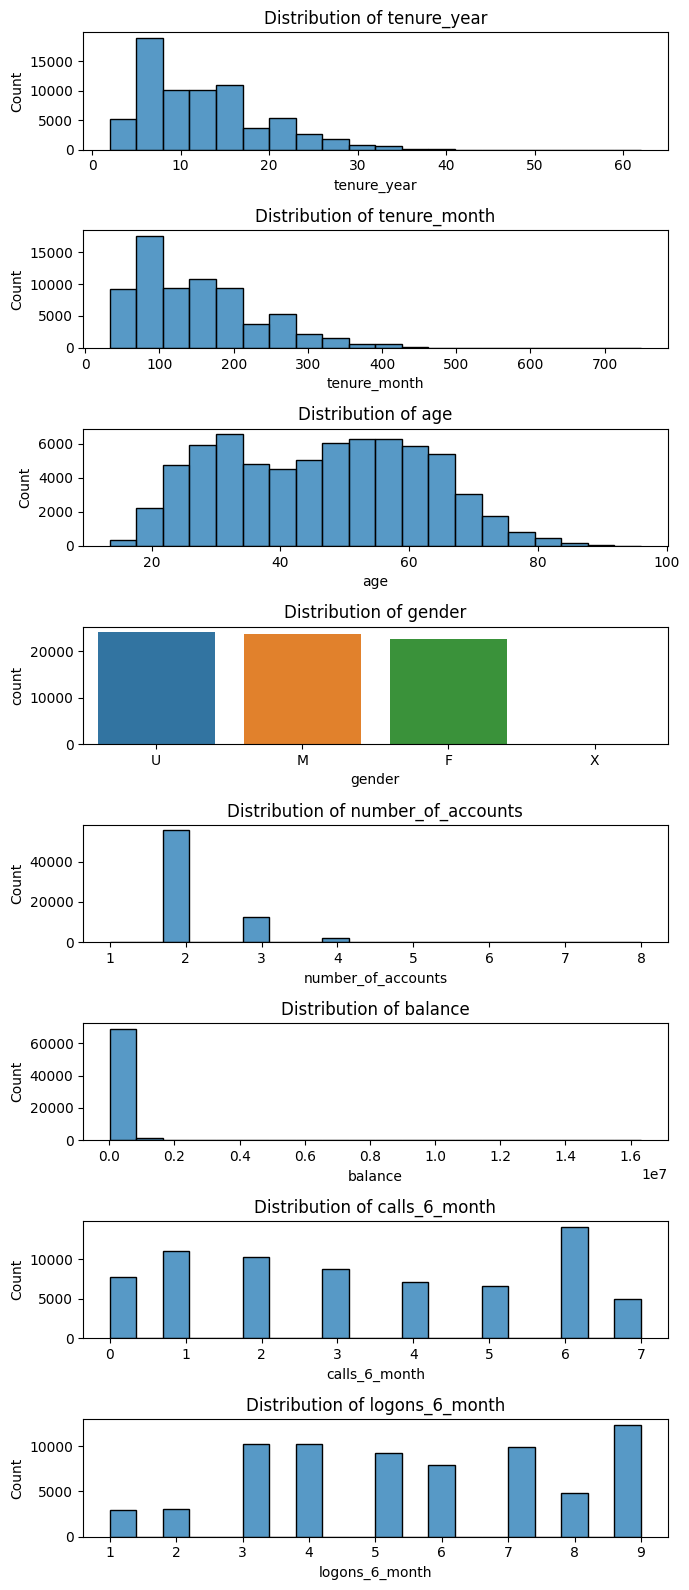

In [32]:
# Get all column names except 'client_id'
selected_columns = df_demographics.columns[~df_demographics.columns.isin(['client_id'])]

# Set figure size based on the number of subplots
n_cols = 1  # Number of columns in the grid layout
n_rows = len(selected_columns) # I calculate the number of rows needed

# Create a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 2 * n_rows))

# Loop through each selected column and plot based on their type
# I choose to use enumerate to add a counter to each item and create an enumerate object. 
# Each column name will come with its number (starting from 0).
for i, col in enumerate(selected_columns):
    if df_demographics[col].dtype in ['int64', 'float64']:
        sns.histplot(df_demographics[col].dropna(), ax=axs[i], bins=20, stat="count")
    else:
        # for the gender column
        sns.countplot(x=df_demographics[col].dropna(), ax=axs[i])
    axs[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

### Comments on the demographics plots

**1. Distribution of tenure_year:** The distribution is skewed to the right (peak on the left), indicating that a majority of individuals have lower tenure years, while a smaller portion has been clients for a longer duration.

**2. Distribution of tenure_month:** Similar to the tenure_year distribution, it appears to be right-skewed, suggesting that a larger proportion of individuals have been clients for a shorter duration.

**3. Distribution of age:** The age distribution seems to be roughly bell-shaped, indicating a near-normal distribution. This suggests that the clients have a good mix across different age groups.

**4. Distribution of gender:** About a third of the clients have not provided their gender (U). From those that have, males are slightly more than females.

**5. Distribution of number_of_accounts:** The distribution is heavily skewed to the right, with most clients holding 2 accounts and a rapid decline in the number of individuals with more accounts.

**6. Distribution of balance:** The distribution is also skewed to the right, with a large number of individuals having relatively low balances.

**7. Distribution of calls_6_month:** The distribution is relatively uniform with a peak at 6 calls. This suggests that there is no significant concentration of individuals making a specific number of calls within the 6-month period.

**8. Distribution of logons_6_month:** The distribution is also relatively uniform with a peak at 9 logins. Similar to the call distribution, there doesn't seem to be a strong concentration of individuals with a particular login frequency.

**Further Considerations:** 
- We can segment age into groups to explore behavioral patterns across age ranges, for example to check if age correlates with balance, calls_6_month, or logons_6_month.
- Check if holding multiple accounts impacts engagement or conversion in the A/B test.
- Verify if the Test and Control groups are balanced across key demographics (e.g., age, gender, balance).

We will now check for tenure year outliers, as the group was founded in 1975, i.e. 42 years prior to the dataset being provided, so it feels suspicious to see values reaching 60 years:

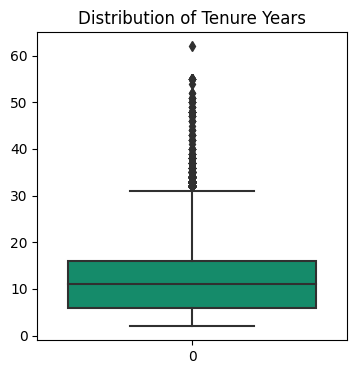

Number of clients with over 42 tenure years: 67 out of a total 70609


In [33]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_demographics['tenure_year'], color=palette[2])
plt.title('Distribution of Tenure Years') 

plt.show()

print("Number of clients with over 42 tenure years:", (df_demographics['tenure_year'] > 42).sum(),"out of a total",len(df_demographics))

Regarding these outliers, we can check the following:
- Are they high-value clients with large balances?
- Do they behave differently in terms of activity (e.g., calls or logins)?

In [36]:
# Separate outliers
outliers = df_demographics[df_demographics['tenure_year'] > 42]

# Non-outliers
non_outliers = df_demographics[df_demographics['tenure_year'] <= 42]

In [37]:
print("Outliers balance statistics:")
print(outliers['balance'].describe())
print("\nNon-outliers balance statistics:")
print(non_outliers['balance'].describe())

Outliers balance statistics:
count        67.00
mean     368171.52
std      457130.32
min       14167.31
25%       70815.78
50%      149881.38
75%      438176.56
max     1874019.73
Name: balance, dtype: float64

Non-outliers balance statistics:
count      70542.00
mean      147218.90
std       301223.11
min        13789.42
25%        37345.83
50%        63312.62
75%       137283.28
max     16320040.15
Name: balance, dtype: float64


Outliers (clients with tenure > 42 years) have, on average, higher balances than non-outliers. Since they represent high-value clients with significantly larger balances, removing them could bias the analysis and miss out on potential insights about long-term, high-value customers.
<br>Let's also compare activity metrics (calls_6_month and logons_6_month) for outliers vs. non-outliers:

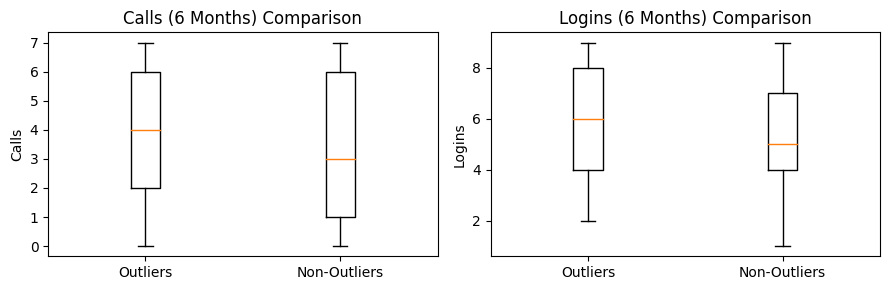

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

axes[0].boxplot([outliers['calls_6_month'], non_outliers['calls_6_month']], labels=['Outliers', 'Non-Outliers'])
axes[0].set_title('Calls (6 Months) Comparison')
axes[0].set_ylabel('Calls')

axes[1].boxplot([outliers['logons_6_month'], non_outliers['logons_6_month']], labels=['Outliers', 'Non-Outliers'])
axes[1].set_title('Logins (6 Months) Comparison')
axes[1].set_ylabel('Logins')

plt.tight_layout()
plt.show()

Calls and logons between the two groups appear similar, with slightly more for the outliers.

## 2.2. Web Data dataframe

I'll merge the experiment client data with the web dataframe, to get a first idea of the comparison in the activity between the test and control sessions:

In [41]:
# Merge files
df_web_data_exp = pd.merge(df_web_data, df_experiment_clients, on="client_id")

df_web_data_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317235 entries, 0 to 317234
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     317235 non-null  object        
 1   visitor_id    317235 non-null  object        
 2   visit_id      317235 non-null  object        
 3   process_step  317235 non-null  object        
 4   date_time     317235 non-null  datetime64[ns]
 5   variation     317235 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 14.5+ MB


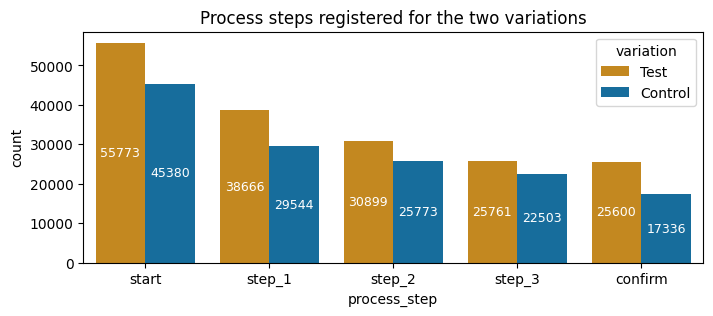

In [42]:
# Define the order of process steps
process_step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(8, 3))
 
# drawing the plot
sns.countplot(x ='process_step', data = df_web_data_exp, palette = [palette[1],palette[0]], order=process_step_order, hue = 'variation')
# Get the containers for the bar plots
containers = ax.containers

# Add white labels below each bar
for c in containers:
    ax.bar_label(c, color='white', fmt='%d', label_type='center', fontsize=9)

plt.title('Process steps registered for the two variations') 
plt.show()

We notice that οut of the processes started, less than half reach the confirm stage. 

Is each individual user logging in more times for the test compared to the control interface?
<br>I will next count the visit_id for each client_id:

In [47]:
df_web_data_visits = df_web_data_exp.groupby(['client_id', 'variation']).agg(
    total_visits=('visit_id', 'count')
# I use reset_index() to turn client_id and variation from index columns to normal ones:
).reset_index() 

Let's have a look at total_visits, to ensure it has no missing or anomalous data:

In [49]:
print("Missing values in total_visits:", df_web_data_visits['total_visits'].isnull().sum())
print("\nDescriptive stats for total_visits:\n", df_web_data_visits['total_visits'].describe())

Missing values in total_visits: 0

Descriptive stats for total_visits:
 count   50500.00
mean        6.28
std         4.03
min         1.00
25%         5.00
50%         5.00
75%         7.00
max        72.00
Name: total_visits, dtype: float64


And now let's merge the two dataframes:

In [50]:
df_web_data_exp_visits = pd.merge(
    df_web_data_exp,
    # Drop variation from df_web_data_visits before the merge to avoid redundant columns
    df_web_data_visits.drop('variation', axis=1).rename(columns={'total_visits': 'user_total_visits'}),
    on='client_id',
    how='left'
)

In [51]:
df_web_data_exp_visits.head()

,client_id,visitor_id,visit_id,process_step,date_time,variation,user_total_visits
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,15
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,15
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,15
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,15
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,15


I'll define a function that will calculate percentiles which will help me understand the spread and distribution of data:
- Q1 (First Quartile): The 25th percentile of the dataset. It is the median of the lower half of the data, meaning that 25% of the data points are below Q1.
- Q3 (Third Quartile): The 75th percentile of the dataset. It is the median of the upper half of the data, meaning that 75% of the data points are below Q3.
- Upper Whisker – The upper whisker in a boxplot represents the largest data point that is not considered an outlier.

In [52]:
# Calculate Summary Stats for Each Variation Group
def calculate_whiskers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + 1.5 * IQR
    return Q1, Q3, upper_whisker

# Group by variation and calculate Q1, Q3, and upper whisker
group_stats = df_web_data_exp_visits.groupby('variation')['user_total_visits'].apply(calculate_whiskers)

# Convert the result to a DataFrame
group_stats = group_stats.apply(pd.Series)
# Q3 is the value at the 75th percentile of the data
# The upper whisker represents the largest data point that is not an outlier
group_stats.columns = ['Q1', 'Q3', 'upper_whisker']
print(group_stats)

x_order = df_web_data_exp_visits['variation'].unique()
group_stats = group_stats.loc[x_order]

            Q1    Q3  upper_whisker
variation                          
Control   5.00 10.00          17.50
Test      5.00 11.00          20.00


And let's plot the data:

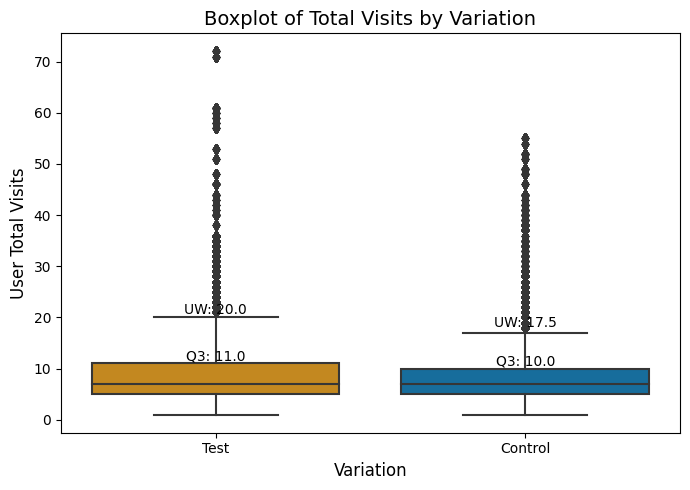

In [53]:
# I'll use a boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(x='variation', y='user_total_visits', data=df_web_data_exp_visits, palette=[palette[1], palette[0]])

plt.title("Boxplot of Total Visits by Variation", fontsize=14)
plt.xlabel("Variation", fontsize=12)
plt.ylabel("User Total Visits", fontsize=12)

# Annotations on the chart
for i, variation in enumerate(group_stats.index):
    upper_whisker = group_stats.loc[variation, 'upper_whisker']
    Q3 = group_stats.loc[variation, 'Q3']
    
    # Annotate Upper Whisker
    plt.text(i, upper_whisker, f"UW: {upper_whisker:.1f}", ha='center', va='bottom', fontsize=10, color='black')
    
    # Annotate Q3 
    plt.text(i, Q3, f"Q3: {Q3:.1f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

There are outliers beyond the upper whiskers in both groups, that have visited the site e.g. for 40 or 60 times, compared to an average 6-7 for most users. Could they have been procrastinating, having other technical issues, getting used to the new interface or even keeping a webpage open and it reloading every time they log in? Either way, they might disproportionately influence metrics such as the mean and variance, leading to misleading results.  

Instead of capping or removing those clients, I will keep only the most recent visits for each of them. I assume that these visits will have allowed them to get used to a new interface, as what we want to establish is the best user experience in the long term; the 'control' interface has presumably been around for some time already, so we could be drawing wrong conclusions when comparing something clients are accustomed to, to something new. Also these last visits are more likely to have been serious attempts at completing the process.

I will thus order their visits chronologically, keeping only the last ones that are equal in number to the value of the Q3  limit. So for example, if an individual has registered 70 visits, we would drop the first 70 - Q3 = X1 visits, and keep the remaining for analysis. This will limit the analysis to a consistent, statistically valid number of visits (based on the Q3 threshold), maintaining a meaningful subset of their visits.

In [55]:
# numpy quantile computes the qth quantile of the given data along the specified axis
Q3 = df_web_data_exp_visits['user_total_visits'].quantile(0.75)
# Find clients with total_visits exceeding Q3
exceeding_clients = df_web_data_exp_visits[df_web_data_exp_visits['user_total_visits'] > Q3]['client_id']

And now let's filter visits for each client:

In [56]:
# Filter for visits exceeding Q3
exceeding_visits = df_web_data_exp_visits[df_web_data_exp_visits['client_id'].isin(exceeding_clients)]

# Define a function to keep only the last Q3 visits for each client
def keep_last_q3_visits(group, q3_value):
    # Sort by visit_id (alphabetical = chronological in this case)
    group = group.sort_values(by='visit_id', ascending=True)
    # Keep only the last Q3 visits
    return group.iloc[-int(q3_value):]

# Apply this function to the exceeding visits
filtered_exceeding_visits = exceeding_visits.groupby('client_id').apply(keep_last_q3_visits, q3_value=Q3)

# Combine filtered visits with non-exceeding visits
remaining_visits = df_web_data_exp_visits[~df_web_data_exp_visits['client_id'].isin(exceeding_clients)]
df_web_data_filtered = pd.concat([remaining_visits, filtered_exceeding_visits]).reset_index(drop=True)

In [57]:
# Check total visits for each client after filtering
df_web_data_visits_filtered = df_web_data_filtered.groupby('client_id').agg(
    total_visits=('visit_id', 'count')
)

print(df_web_data_visits_filtered['total_visits'].describe())

count   50500.00
mean        5.77
std         2.53
min         1.00
25%         5.00
50%         5.00
75%         7.00
max        10.00
Name: total_visits, dtype: float64


In [58]:
df_web_data_filtered.head()

,client_id,visitor_id,visit_id,process_step,date_time,variation,user_total_visits
0,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05,Test,5
1,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43,Test,5
2,8320017,39393514_33118319366,960651974_70596002104_312201,step_2,2017-04-05 13:08:40,Test,5
3,8320017,39393514_33118319366,960651974_70596002104_312201,step_1,2017-04-05 13:08:24,Test,5
4,8320017,39393514_33118319366,960651974_70596002104_312201,start,2017-04-05 13:08:06,Test,5


## 2.3. Experiment Clients dataframe

Let's see the distribution of the clients between the Test and Control variations:

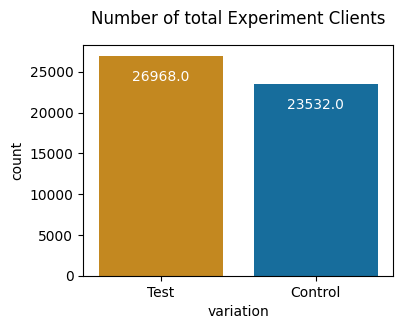

In [61]:
fig, ax = plt.subplots(figsize=(4, 3))

# I'll use a countplot
fig = sns.countplot(x='variation', data=df_experiment_clients, palette=[palette[1], palette[0]])

# Add labels 
for container in ax.containers:
    for bar in container:
        # get the height of the bar and the x-position
        yval = bar.get_height()
        xval = bar.get_x() + bar.get_width() / 2
        # Add label below the top of the bar (by adjusting yval)
        ax.text(xval, yval - 3500, f'{yval}', ha='center', va='bottom', fontsize=10, color='white')

ax.set_title('Number of total Experiment Clients', y=1.0, pad=15)

plt.show()

**Comments on the Experiment Clients plot:** There are more clients who went through the test variation, so this will probably result to more steps counted in the respective steps etc., in total numbers.

## 2.4. Relationships between parameters (Bivariate Analysis)

I'll merge the demographics and experiment dataset, as the variation is a key attribute in my analysis:

In [63]:
# Merge files
df_demographics = pd.merge(df_demographics, df_experiment_clients, on="client_id")

df_demographics.head()

,client_id,tenure_year,tenure_month,age,gender,number_of_accounts,balance,calls_6_month,logons_6_month,variation
0,836976,6.00,73.00,60.50,U,2.00,45105.30,6.00,9.00,Test
1,2304905,7.00,94.00,58.00,U,2.00,110860.30,6.00,9.00,Control
2,1439522,5.00,64.00,32.00,U,2.00,52467.79,6.00,9.00,Test
3,1562045,16.00,198.00,49.00,M,2.00,67454.65,3.00,6.00,Test
4,5126305,12.00,145.00,33.00,F,2.00,103671.75,0.00,3.00,Control


First we will check the correlation of the parameters inside the demographics dataframe. I will convert categorical variables (gender and variation) to numerical values temporarily for the correlation matrix and visualize it using a heatmap:

In [69]:
# Convert categorical variables to numeric
df_demographics["gender_num"], gender_mapping = pd.factorize(df_demographics["gender"])
df_demographics["variation_num"], variation_mapping = pd.factorize(df_demographics["variation"])

# Print the mappings
print("Gender Mapping:")
for num, category in enumerate(gender_mapping):
    print(f"{category} → {num}")

print("\nVariation Mapping:")
for num, category in enumerate(variation_mapping):
    print(f"{category} → {num}")

Gender Mapping:
U → 0
M → 1
F → 2
X → 3

Variation Mapping:
Test → 0
Control → 1


In [70]:
# Drop non-numeric and redundant columns
df_numeric = df_demographics.drop(columns=["client_id", "gender", "variation"])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

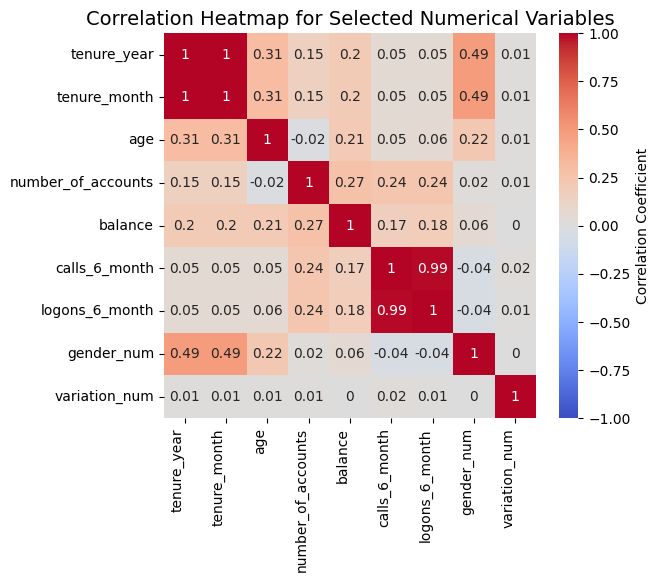

In [66]:
# Create the heatmap 
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(round(correlation_matrix, 2), annot=True, ax=ax,
            cmap="coolwarm", vmin=-1, vmax=1,
            cbar_kws={"label": "Correlation Coefficient"}) 

# Add labels and title
plt.title("Correlation Heatmap for Selected Numerical Variables", fontsize=14)
plt.xticks(ha="right", fontsize=10)  
plt.yticks(fontsize=10)
plt.show()

### Observations 

The color intensity represents the strength of the correlation, with red indicating positive correlations and grey indicating no correlation.


1. There is a perfect positive correlation (0.99) between **calls and logons**. This suggests that individuals who make more calls within 6 months also register a higher number of logins during the same period. This is expected as increased activity often leads to both increased calls and logins. The strong correlation between these two suggests that these variables may be redundant and that including both in a model might lead to multicollinearity.
2. **Gender** has a correlation of ~0.49 with tenure_year and tenure_month. This suggests that gender is moderately associated with tenure, meaning certain gender groups may have a longer tenure on average. It also has a weak correlation with age (0.22), but not strong enough to draw conclusions.
3. **Variation** has near-zero correlations with all numerical variables. This suggests that the variation assignment was likely random, which is good for A/B testing.
4. **Tenure year** and age have a moderate positive correlation (0.31), which is expected.
5. **Number of accounts** shows moderate positive correlations with balance (0.27) and calls_6_month (0.24). This suggests that individuals with more accounts tend to have higher balances and are more likely to make calls. This might provide some insights into potential relationships between customer behavior and account characteristics. Understanding the types of accounts and the typical customer behavior can help explain the observed patterns.
6. Most other correlations are relatively weak (values close to 0), indicating little to no linear relationship between those variables.


# 3. Experimental Metric & KPIs

In this section we will set the key performance indicators (KPIs) for assessing the effectiveness of Vanguard’s new digital interface, to compare the performance of the Test Group against the Control Group.

**1. The completion rate:** indicates the number of visits which reach the final 'confirm' step.

**2. Time Spent on Each Step:** The average duration users spend on each step.

**3. Error Rates:** If there’s a step where a) users go back to a previous step or b) repeat it, it may indicate confusion or an UI error.
 
**4. Drop-off Rate per Step:** The proportion of users that exit the process at each step.

We'll start by joining our tables:

In [72]:
# merge all the dataframes on client_id
df_merge_1 = pd.merge(df_web_data_filtered.drop('variation', axis=1), df_experiment_clients, on='client_id', how='inner')
df_whole = pd.merge(df_merge_1, df_demographics.drop('variation', axis=1), on='client_id', how='inner')

# format datetime and add date and month column
# the date value will not include the time
df_whole['date'] = df_whole['date_time'].dt.date
df_whole['date'] = pd.to_datetime(df_whole['date'], errors='coerce')
# extract the month
df_whole['month'] = df_whole['date_time'].dt.strftime('%B')

In [73]:
df_whole.head()

,client_id,visitor_id,visit_id,process_step,date_time,user_total_visits,variation,tenure_year,tenure_month,age,gender,number_of_accounts,balance,calls_6_month,logons_6_month,gender_num,variation_num,date,month
0,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05,5,Test,22.00,274.00,34.50,M,2.00,36001.90,5.00,8.00,1,0,2017-04-05,April
1,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43,5,Test,22.00,274.00,34.50,M,2.00,36001.90,5.00,8.00,1,0,2017-04-05,April
2,8320017,39393514_33118319366,960651974_70596002104_312201,step_2,2017-04-05 13:08:40,5,Test,22.00,274.00,34.50,M,2.00,36001.90,5.00,8.00,1,0,2017-04-05,April
3,8320017,39393514_33118319366,960651974_70596002104_312201,step_1,2017-04-05 13:08:24,5,Test,22.00,274.00,34.50,M,2.00,36001.90,5.00,8.00,1,0,2017-04-05,April
4,8320017,39393514_33118319366,960651974_70596002104_312201,start,2017-04-05 13:08:06,5,Test,22.00,274.00,34.50,M,2.00,36001.90,5.00,8.00,1,0,2017-04-05,April


Drop the columns we will not be using:
- Tenure month is perfectly correlated (1.0) with tenure year, so we will only keep the second in the set
- We're keeping the date column, so the date_time one won't be needed
- Visitor id is redundant as the client id already provides the information
- Before dropping calls_6_month and logons_6_month, we will create a composite variable (total_activity). This will make sure we capture the engagement behavior as a single metric.

In [74]:
# Create the composite variable
df_whole['total_activity'] = df_whole['calls_6_month'] + df_whole['logons_6_month']

# Define columns to drop
irrelevant_columns = ['tenure_month', 'number_of_accounts', 'calls_6_month', 
                      'logons_6_month', 'visitor_id']

# Drop irrelevant columns and remove duplicates
df_whole = df_whole.drop(columns=irrelevant_columns).drop_duplicates().reset_index(drop=True)

Let's have a look at the processes initiated for both the test and control variations over time:

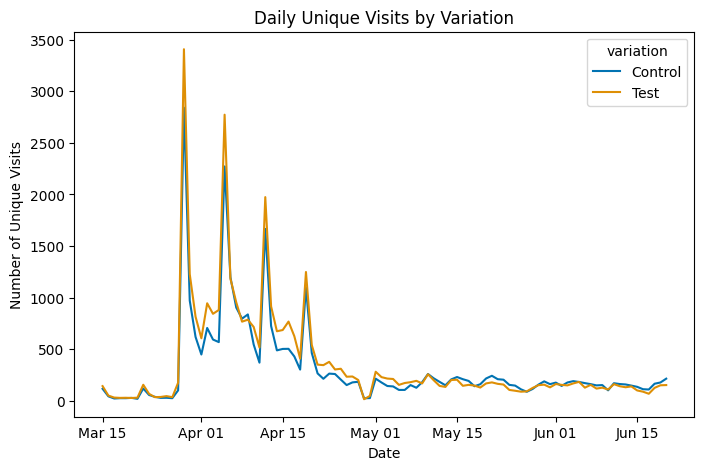

In [76]:
# Group by date and variation, count unique visit_ids
daily_visits = df_whole.groupby(['date', 'variation'])['visit_id'].nunique().reset_index(name='unique_visits')

# Create the lineplot with a figure size of 6x5
fig, ax = plt.subplots(figsize=(8, 5))  # Combine figure creation and lineplot

sns.lineplot(x='date', y='unique_visits', hue='variation', data=daily_visits, ax=ax, palette = palette[:2])  # Pass ax to sns.lineplot

# Format x-axis ticks to show only day and month
plt.xlabel('Date')
plt.ylabel('Number of Unique Visits')
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))  # '%b' for month abbreviation, '%d' for day

plt.title('Daily Unique Visits by Variation')
plt.show()

There appear to be more visits for the test variation over the first days of the examined period. Could that be because users are not used to the new interface and are thus failing and re-logging on to have a second try on it?

In [77]:
variation_totals = df_whole.groupby(['variation']).size()

In [78]:
print(f"Test  size: {variation_totals.loc['Test']}, Control size: {variation_totals.loc['Control']}")

Test  size: 161010, Control size: 130314


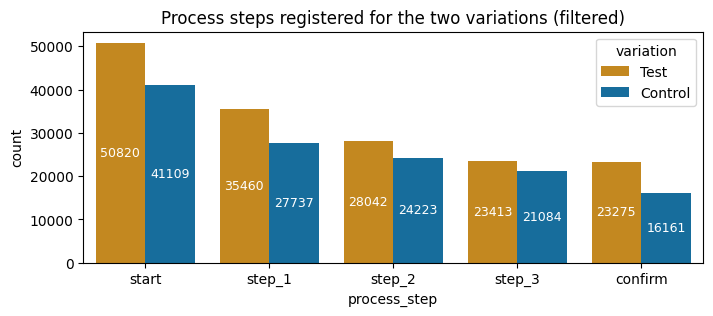

In [89]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(8, 3))
 
# drawing the plot
sns.countplot(x ='process_step', data = df_whole, palette = [palette[1],palette[0]], order=process_step_order, hue = 'variation')
# Get the containers for the bar plots
containers = ax.containers

# Add white labels below each bar
for c in containers:
    ax.bar_label(c, color='white', fmt='%d', label_type='center', fontsize=9)

plt.title('Process steps registered for the two variations (filtered)') 
plt.show()

The result tells us that there are more data entries for the Test variation, compared to the Control one. The count of total steps is higher for the test variation, however so are the clients trying it out, so it seems reasonable.

How about the users' age? Are the equally distributed between the variations?

In [80]:
# I'll create age bins to help me get some insights
bins = [18, 30, 40, 50, 60, 70, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_whole['age_group'] = pd.cut(df_whole['age'], bins=bins, labels=labels)

In [82]:
# Count the number of clients in each age group per variation. The new column we will named 'count'
age_group_stats = df_whole.groupby(['variation', 'age_group'])['client_id'].count().reset_index(name='count')

# Calculate the total clients per variation
total_clients_per_variation = age_group_stats.groupby('variation')['count'].sum().reset_index(name='total_clients')

# Merge the total clients with age group counts
age_group_stats = age_group_stats.merge(total_clients_per_variation, on='variation')

# Calculate the rate of each age group within each variation
age_group_stats['rate'] = age_group_stats['count'] / age_group_stats['total_clients'] 

print(age_group_stats)

   variation age_group  count  total_clients  rate
0    Control     18-29  22105         129970  0.17
1    Control     30-39  22964         129970  0.18
2    Control     40-49  22568         129970  0.17
3    Control     50-59  29501         129970  0.23
4    Control     60-69  24180         129970  0.19
5    Control       70+   8652         129970  0.07
6       Test     18-29  27053         160639  0.17
7       Test     30-39  28619         160639  0.18
8       Test     40-49  27439         160639  0.17
9       Test     50-59  36783         160639  0.23
10      Test     60-69  30148         160639  0.19
11      Test       70+  10597         160639  0.07


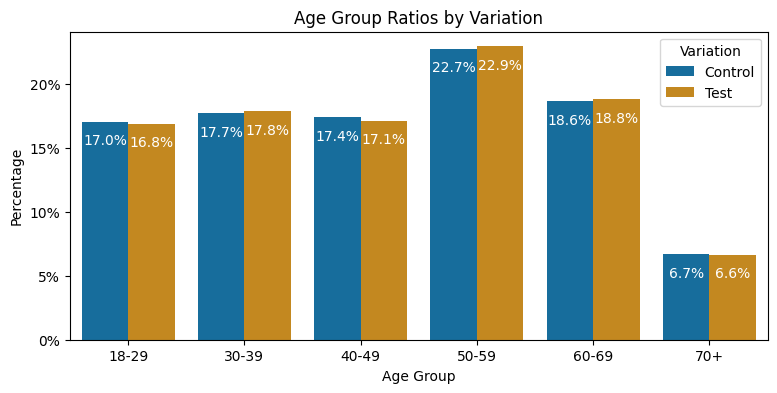

In [87]:
plt.figure(figsize=(9, 4))
sns.barplot(data=age_group_stats, x='age_group', y='rate', hue='variation', palette=palette)

# Format the y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Add labels
for container in plt.gca().containers:
    for patch in container:
        height = patch.get_height()
        plt.text(patch.get_x() + patch.get_width() / 2, height - 0.02, f'{height:.1%}',
                 ha='center', va='bottom', color='white')

plt.title('Age Group Ratios by Variation')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Variation')

plt.show()

Age groups are therefore equally distributed between the test and control groups.

## 3.1. Completion rates

We also want to assess whether the confirm stage was reached in each of the unique visits.

We will create a new column called 'confirm_check' in the dataframe. For each visit_id group, the 'confirm_check' column will be assigned "confirm" if the string "confirm" is found within the process_step values of that group, and "no_confirm" otherwise.

In [92]:
# Identify visits with 'confirm' process step
# these are the visits that have 'confirm' registered as one of their steps
confirm_visits = df_whole[df_whole['process_step'] == 'confirm']['visit_id'].unique()
# so assign them a 'confirm' value if True, or no_confirm if it isn't
df_whole['confirm_check'] = df_whole['visit_id'].isin(confirm_visits).map({True: 'confirm', False: 'no_confirm'})

# Calculate total unique visits for both variations
total_visits = df_whole.groupby('variation')['visit_id'].nunique()

# Calculate totals per variation
n_test_total = df_whole.groupby('variation')['visit_id'].nunique()['Test']
n_control_total = df_whole.groupby('variation')['visit_id'].nunique()['Control']

# Calculate confirmed visits for each variation
confirmed_visits = df_whole[df_whole['confirm_check'] == 'confirm'].groupby('variation')['visit_id']

# also total visits with no_cofirm per variation
n_test_nonvalidated = confirmed_visits.nunique()['Test']
n_control_nonvalidated = confirmed_visits.nunique()['Control']

# Calculate proportions
p_test_nonvalidated = n_test_nonvalidated / n_test_total
p_control_nonvalidated = n_control_nonvalidated / n_control_total

# Print the results
print(f"Out of the total {n_test_total} test sessions, {n_test_nonvalidated} have reached the 'confirm' step.")
print(f"Out of the total {n_control_total} control sessions, {n_control_nonvalidated} have reached the 'confirm' step.")

Out of the total 35498 test sessions, 20067 have reached the 'confirm' step.
Out of the total 30852 control sessions, 15088 have reached the 'confirm' step.


**Important:** Reaching the 'confirm' step doesn't necessarily mean that one has been through all the previous steps, i.e. it doesn't mean that the process was valid. I don't want to mistakenly register visits as valid, when they are not!

Had the session that reached the confirm step first been through all the (required) previous steps?

In [94]:
def validate_visit_steps(df):    
    # Group by visit_id and collect the unique process_step values for each group
    grouped_steps = df.groupby('visit_id')['process_step'].apply(set)

    # Use predefined process_step_order as required steps
    # set() function creates a set object, i.e. a sequence of iterable elements with distinct elements
    required_steps = set(process_step_order)
    
    # Extract confirmed visit_ids for Test and Control groups
    confirmed_visits_test = df.loc[
        (df['confirm_check'] == 'confirm') & (df['variation'] == 'Test'), 'visit_id'
    ].unique()
    
    confirmed_visits_control = df.loc[
        (df['confirm_check'] == 'confirm') & (df['variation'] == 'Control'), 'visit_id'
    ].unique()
    
    # Filter confirmed visit_ids to ensure they exist in grouped_steps
    confirmed_visits_test = [visit_id for visit_id in confirmed_visits_test if visit_id in grouped_steps.index]
    confirmed_visits_control = [visit_id for visit_id in confirmed_visits_control if visit_id in grouped_steps.index]

    # Check if each confirmed visit_id has all the required steps
    valid_visits_test = grouped_steps.loc[confirmed_visits_test].apply(lambda steps: required_steps.issubset(steps))
    valid_visits_control = grouped_steps.loc[confirmed_visits_control].apply(lambda steps: required_steps.issubset(steps))
    
    # Count valid and invalid visits
    n_test_validated, n_test_false = valid_visits_test.sum(), valid_visits_test.size - valid_visits_test.sum()
    n_control_validated, n_control_false = valid_visits_control.sum(), valid_visits_control.size - valid_visits_control.sum()

    # Print the results
    print(f"Valid visit_ids for test dataset (True): {n_test_validated}")
    print(f"Invalid visit_ids for test dataset (False): {n_test_false} ({n_test_false / (n_test_validated + n_test_false):.2%})")
    print(f"Valid visit_ids for control dataset (True): {n_control_validated}")
    print(f"Invalid visit_ids for control dataset (False): {n_control_false} ({n_control_false / (n_control_validated + n_control_false):.2%})")

    return valid_visits_test, valid_visits_control, n_test_validated, n_test_false, n_control_validated, n_control_false

# Capture the returned values 
valid_visits_test, valid_visits_control, n_test_validated, n_test_false, n_control_validated, n_control_false = validate_visit_steps(df_whole)

Valid visit_ids for test dataset (True): 16541
Invalid visit_ids for test dataset (False): 3526 (17.57%)
Valid visit_ids for control dataset (True): 13903
Invalid visit_ids for control dataset (False): 1185 (7.85%)


So it appears that a high number (17.6%) of the visits is not valid in the test dataset, as they have registered the 'confirm' stage without having taken all the previous required steps. This drops to 7.9% in the control dataset - which is an important difference. This indicates a potential issue in the test version where users may be able to bypass the required steps more easily.

I will not drop these entries, because I assume that the application allows for jumping straight to the confirm step, hence they are not necessarily wrong entries. I will instead use this 'invalid submission' as a metric to compare the test and control versions. 

The **valid** completion rates will be calculated as follows:

$$
\hat{p}_{\text{test}} = \frac{\text{completion\_test}}{\text{total\_visits\_test}}
$$

$$
\hat{p}_{\text{control}} = \frac{\text{completion\_control}}{\text{total\_visits\_control}}
$$

In [95]:
p_test_validated = valid_visits_test.sum() / n_test_total
p_control_validated = valid_visits_control.sum() / n_control_total

print(f"Valid completion rate for test dataset (True): {p_test_validated:.2%}")
print(f"Valid completion rate for control dataset (True): {p_control_validated:.2%}")

Valid completion rate for test dataset (True): 46.60%
Valid completion rate for control dataset (True): 45.06%


Let's plot the valid completed sessions for each variation:

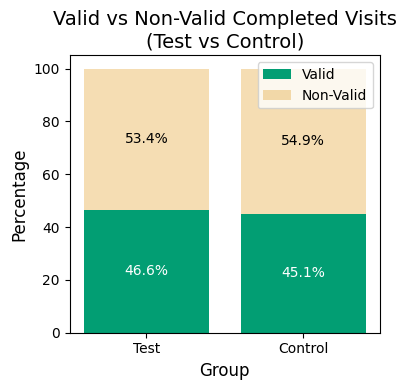

In [96]:
# Calculating confirmed and non-confirmed percentages
validated_percent = np.array([p_test_validated, p_control_validated]) * 100
non_validated_percent = np.array([1 - p_test_validated, 1 - p_control_validated]) * 100

# Labels 
labels = ['Test', 'Control']

fig, ax = plt.subplots(figsize=(4, 4))
index = np.arange(len(labels))

# Plot the bars with separate colors for Test and Control
bars_confirmed = ax.bar(index, validated_percent, label='Valid',
                        color=palette[2])
bars_non_confirmed = ax.bar(index, non_validated_percent, bottom=validated_percent,
                            label='Non-Valid',
                            color=palette[1], alpha=0.3)

# Add percentage labels to each segment
for i, (vp, nvp) in enumerate(zip(validated_percent, non_validated_percent)):
    ax.text(i, vp / 2, f'{vp:.1f}%', ha='center', va='center', color='white', fontsize=10)
    ax.text(i, vp + nvp / 2, f'{nvp:.1f}%', ha='center', va='center', color='black', fontsize=10)

ax.set_xlabel('Group', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Valid vs Non-Valid Completed Visits\n(Test vs Control)', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

Valid visits between the two interfaces appear quite close to each other. We will now calculate the completion rate at each step for the two variations ("Test" and "Control"):

In [97]:
# Ensure the dataframe is sorted by visit_id and date_time
df_whole.sort_values(by=['variation', 'visit_id', 'date_time'], inplace=True)

# Create a function to check step completion conditions
def calculate_completion_rate_per_variation(df, process_step_order):
    # Initialize a dictionary to store step completion counts per variation
    completion_rates_per_variation = {}

    # Group by variation
    for variation, variation_group in df.groupby('variation'):
        step_completion = {step: 0 for step in process_step_order}
        total_visits = len(variation_group['visit_id'].unique())

        # Iterate over each visit_id in the variation
        for visit_id, group in variation_group.groupby('visit_id'):
            group_steps = group['process_step'].tolist()

            # Check each step's completion
            for step in process_step_order:
                # Check if all preceding steps and current step are in the group
                if all(s in group_steps for s in process_step_order[:process_step_order.index(step) + 1]):
                    step_completion[step] += 1

        # Calculate completion rates for this variation
        step_completion_rate = {step: completion / total_visits for step, completion in step_completion.items()}
        completion_rates_per_variation[variation] = step_completion_rate

    return completion_rates_per_variation

# Calculate completion rates per variation
completion_rates_variation = calculate_completion_rate_per_variation(df_whole, process_step_order)

# Display completion rates per variation
print("Completion Rates by Process Step per Variation:")
for variation, rates in completion_rates_variation.items():
    print(f"Variation: {variation}")
    for step, rate in rates.items():
        print(f"  {step}: {rate:.2%}")

Completion Rates by Process Step per Variation:
Variation: Control
  start: 95.98%
  step_1: 72.68%
  step_2: 61.77%
  step_3: 55.22%
  confirm: 45.01%
Variation: Test
  start: 89.61%
  step_1: 75.38%
  step_2: 64.39%
  step_3: 57.06%
  confirm: 46.57%


And plot the completion rates for the individual steps:

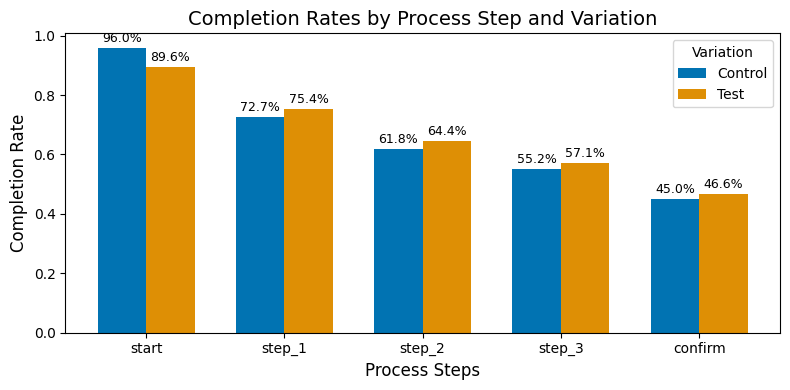

In [98]:
# Prepare data for plotting
variations = list(completion_rates_variation.keys())
steps = list(completion_rates_variation[variations[0]].keys())
data = {step: [completion_rates_variation[var][step] for var in variations] for step in steps}

# Convert data into a matrix for plotting
step_indices = np.arange(len(steps))  # Index for each step
bar_width = 0.35  # Width of each bar

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bars for each variation
for i, variation in enumerate(variations):
    ax.bar(
        step_indices + i * bar_width,
        [data[step][i] for step in steps],
        bar_width,
        label=variation,
        color=palette[i]
    )

ax.set_xlabel('Process Steps', fontsize=12)
ax.set_ylabel('Completion Rate', fontsize=12)
ax.set_title('Completion Rates by Process Step and Variation', fontsize=14)
ax.set_xticks(step_indices + bar_width / 2)  # Center tick labels
ax.set_xticklabels(steps, fontsize=10)
ax.legend(title='Variation', fontsize=10)

# Add percentage labels above bars
for i, variation in enumerate(variations):
    for j, step in enumerate(steps):
        rate = data[step][i]  # Correctly access the rate
        ax.text(
            step_indices[j] + i * bar_width,
            rate + 0.01,
            f"{rate:.1%}",
            ha='center',
            va='bottom',
            fontsize=9,
        )

plt.tight_layout()
plt.show()

It's also interesting to examine the completion rates per age group. I'll start by calculating them:

In [99]:
# Ensure the dataframe is sorted by visit_id and date_time
df_whole.sort_values(by=['variation', 'visit_id', 'date_time'], inplace=True)

# Filter valid completions by ensuring all steps are present
valid_completions = []

# Group by variation and visit_id to check steps
for (age_group, variation, visit_id), group in df_whole.groupby(['age_group', 'variation', 'visit_id']):
    group_steps = group['process_step'].tolist()

    # Check if all steps are completed
    if all(s in group_steps for s in process_step_order):
        valid_completions.append((age_group, variation, visit_id))

# Create a DataFrame of valid completions
valid_completions_df = pd.DataFrame(valid_completions, columns=['age_group', 'variation', 'visit_id'])

# Calculate total visits by age_group and variation
total_visits = (
    df_whole.groupby(['age_group', 'variation'])
    .agg(total_visits=('visit_id', 'nunique'))
    .reset_index()
)

# Calculate valid confirmations (visit_ids in valid_completions)
valid_confirmations = (
    valid_completions_df.groupby(['age_group', 'variation'])
    .agg(valid_confirmations=('visit_id', 'nunique'))
    .reset_index()
)

# Merge valid confirmations and total visits
completion_rates_by_age = pd.merge(
    total_visits,
    valid_confirmations,
    on=['age_group', 'variation'],
    how='left'
)

# Fill missing valid confirmations with 0
completion_rates_by_age['valid_confirmations'] = completion_rates_by_age['valid_confirmations'].fillna(0)

# Calculate valid completion rate
completion_rates_by_age['Valid Completion Rate'] = (
    completion_rates_by_age['valid_confirmations'] / completion_rates_by_age['total_visits']
)

And plotting them:

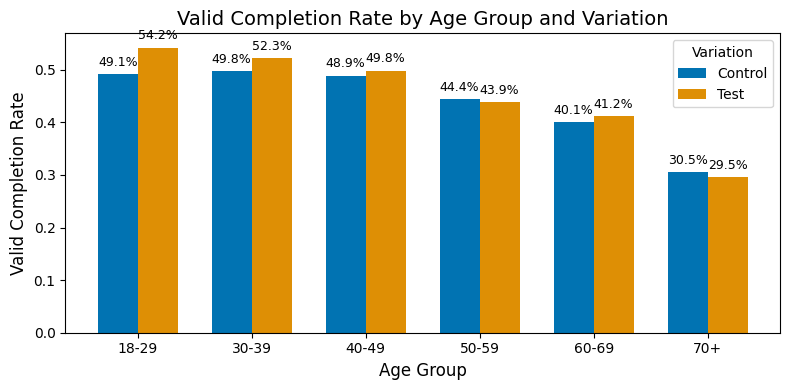

In [101]:
# Prepare data for plotting
variations = completion_rates_by_age['variation'].unique()
age_groups = completion_rates_by_age['age_group'].unique()

# Pivot the data to make it easier to plot
plot_data = completion_rates_by_age.pivot(index='age_group', columns='variation', values='Valid Completion Rate')

# Define positions for bars
bar_width = 0.35
age_indices = np.arange(len(age_groups))

fig, ax = plt.subplots(figsize=(8, 4))

for i, variation in enumerate(variations):
    ax.bar(
        age_indices + i * bar_width,
        plot_data[variation],
        bar_width,
        label=variation,
        color=palette[i]
    )

ax.set_xlabel('Age Group', fontsize=12)
ax.set_ylabel('Valid Completion Rate', fontsize=12)
ax.set_title('Valid Completion Rate by Age Group and Variation', fontsize=14)
ax.set_xticks(age_indices + bar_width / 2)  # Center ticks
ax.set_xticklabels(age_groups, fontsize=10)
ax.legend(title='Variation', fontsize=10)

# Add percentage labels above bars
for i, variation in enumerate(variations):
    for j, rate in enumerate(plot_data[variation]):
        ax.text(
            age_indices[j] + i * bar_width,
            rate + 0.01,
            f"{rate:.1%}",
            ha='center',
            va='bottom',
            fontsize=9,
        )

plt.tight_layout()
plt.show()

The successful completion rates are higher in younger people for the Test variation (18-29 and 30-39 group) and more or less equally distributed in the other age groups.

## 3.2. Time Spent on Each Step


The next metric we need to calculate, is the time taken to complete each step, for each variation. For each unique visit_id, there might be more than one 'step' entries, as the visitors might be going back and forth the steps of the process. With this in mind, I will calculate the total time taken in each step, for each unique visit. This will then be added to the dataframe, under a new 'step_time' column.

In [102]:
# Sort the DataFrame by 'visit_id' and 'date_time' to ensure chronological order
time_spent_df = df_whole.sort_values(by=['visit_id', 'date_time'])

# Calculate the time difference (duration) to the next row within each visit_id
# .diff(-1) calculates the difference between the current row and the next row. I also make sure the absolute number is used.
# The time difference is then assigned to the current process_step.
time_spent_df['time_to_next_step'] = time_spent_df.groupby('visit_id')['date_time'].diff(-1).abs()

# Convert each timedelta object in the series into the total number of seconds it represents
time_spent_df['time_to_next_step'] = time_spent_df['time_to_next_step'].dt.total_seconds()

# Set 'time_to_next_step' to na if the process_step is 'confirm'
time_spent_df.loc[time_spent_df['process_step'] == 'confirm', 'time_to_next_step'] = np.nan

We will now group by 'visit_id' and 'process_step' to sum the total time spent on each step. This gives us the total time spent in that particular step during the visit (even when the step has been repeated).

In [103]:
# Group by 'visit_id' and 'process_step' while preserving NaN values
df_step_times = time_spent_df.groupby(['visit_id', 'process_step'])['time_to_next_step'].sum(min_count=1).reset_index()

# Pivot the table
df_step_times_pivot = df_step_times.pivot(index='visit_id', columns='process_step', values='time_to_next_step').reset_index()

# When the last step of a isn't 'confirm', we have a drop off. These steps should also have 'na' assigned to them
df_step_times_pivot = df_step_times_pivot.where(pd.notna(df_step_times_pivot), np.nan)

# Display the result
df_step_times_pivot.head()

process_step,visit_id,confirm,start,step_1,step_2,step_3
0,100012776_37918976071_457913,NaN,NaN,NaN,NaN,NaN
1,100019538_17884295066_43909,NaN,136.00,NaN,NaN,NaN
2,100022086_87870757897_149620,NaN,22.00,45.00,53.00,60.00
3,100030127_47967100085_936361,NaN,NaN,NaN,NaN,NaN
4,100037962_47432393712_705583,NaN,124.00,8.00,NaN,NaN


<div id="stepTimeStats">
Let's calculate the descriptive stats for the steps of each variation, to better understand them:
</div>

In [104]:
time_by_variation = df_step_times_pivot.merge(df_whole[['visit_id', 'variation']].drop_duplicates(), on='visit_id', how='left')
test_time = time_by_variation[time_by_variation['variation'] == 'Test']
control_time = time_by_variation[time_by_variation['variation'] == 'Control']

print("Average Mean Time per Step - Test Variation")
print(test_time.describe())
print("Average Mean Time per Step - Control Variation")
print(control_time.describe())

Average Mean Time per Step - Test Variation
       confirm    start   step_1   step_2   step_3
count     0.00 28634.00 24814.00 22177.00 19474.00
mean       NaN    88.81    83.02   110.26   138.65
std        NaN   330.57   223.07   214.56   283.04
min        NaN     1.00     0.00     0.00     0.00
25%        NaN     9.00    18.00    47.00    33.00
50%        NaN    17.00    34.00    74.00    60.00
75%        NaN    68.00    70.00   120.00   131.00
max        NaN 31624.00 15620.00 16036.00  6760.00
Average Mean Time per Step - Control Variation
       confirm    start   step_1   step_2   step_3
count     0.00 24551.00 20288.00 18204.00 15966.00
mean       NaN    85.57    63.41   116.84   158.66
std        NaN   360.83   221.90   212.45   234.41
min        NaN     1.00     1.00     1.00     1.00
25%        NaN    12.00    11.00    51.00    49.00
50%        NaN    25.00    25.00    82.00    87.00
75%        NaN    59.00    56.00   135.00   170.00
max        NaN 41957.00 16950.00 21763.00 

In [105]:
# Reshape the data to long format
time_long = time_by_variation.melt(
    id_vars=['visit_id', 'variation'], 
    value_vars=['confirm', 'start', 'step_1', 'step_2', 'step_3'], 
    var_name='process_step', 
    value_name='time'
)

# Drop rows with NaN time values 
time_long = time_long.dropna()

# Preview the reshaped data
print(time_long.head())

                           visit_id variation process_step   time
66351   100019538_17884295066_43909      Test        start 136.00
66352  100022086_87870757897_149620      Test        start  22.00
66354  100037962_47432393712_705583   Control        start 124.00
66355  100057941_88477660212_944512   Control        start  30.00
66356   10006594_66157970412_679648   Control        start  10.00


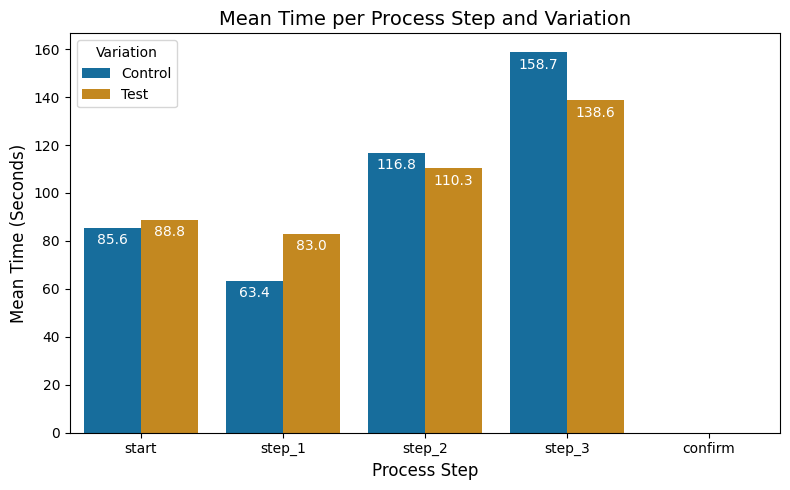

In [106]:
# Group by process_step and variation to calculate mean time
mean_time = time_long.groupby(['process_step', 'variation'])['time'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=mean_time, x='process_step', y='time', hue='variation', palette=palette, order=process_step_order)

# Add labels to the bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height - 8, f'{height:.1f}', 
                   ha='center', va='bottom', fontsize=10, color = 'white')

# Add titles and labels
plt.title('Mean Time per Process Step and Variation', fontsize=14)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Mean Time (Seconds)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Variation')

# Show the plot
plt.tight_layout()
plt.show()

**Comment:** Longer times in step_1 asuggest that the Test variation may have introduced bottlenecks in that step, which could affect user experience and conversion rates. Overall, while the Test group performs better in the steps 2 and 3.

## 3.3. Error Rates

<div id="errorRatesCalcs">We next want to create the experimental metrics and KPIs for Error rates. I will use the following metrics:</div>
<br>

**1. Step repeat errors:** In the chronological sequence of steps ("process_step_order"), if a step name is repeated (e.g. in start, step_1, step_1, step_2 -> step_1 is repeated), it will count as a "steprepeat" error. However, if one visit_id ends at one step (e.g. start) and the next visit starts from the same step (i.e. start) that shouldn't be accounted as a "step repeat" error.

**2. Step back errors:** In the chronological sequence of steps ("process_step_order"), if a step that would preceeds another step in a valid sequence of steps, is given after it (e.g. start, step_1, start), that means that the user went back one step, and that will count as a step back error.

I'll start by creating a dataframe were these errors will be given in separate columns:

In [107]:
# Define process step order
step_map = {step: i for i, step in enumerate(process_step_order)}

# Map process steps to numeric order
df_whole["process_step_order"] = df_whole["process_step"].map(step_map)

# Sort by visit_id and date_time for correct order of events
df_whole = df_whole.sort_values(["visit_id", "date_time"])

# Identify step repeat errors (same step appearing consecutively within the same visit_id)
df_whole["prev_step"] = df_whole.groupby("visit_id")["process_step"].shift(1)
df_whole["step_repeat_error"] = (
    (df_whole["process_step"] == df_whole["prev_step"]) & 
    (df_whole["visit_id"] == df_whole["visit_id"].shift(1))
).astype(int)

# Identify step back errors (previous step has a higher numerical order)
df_whole["prev_step_order"] = df_whole.groupby("visit_id")["process_step_order"].shift(1)
df_whole["step_back_error"] = (
    (df_whole["prev_step_order"] > df_whole["process_step_order"]) & 
    (df_whole["visit_id"] == df_whole["visit_id"].shift(1))
).astype(int)

# Aggregate errors per visit_id and process_step
error_df = df_whole.groupby(["visit_id", "process_step"]).agg(
    variation=("variation", "first"),  
    step_repeat_errors=("step_repeat_error", "sum"),
    step_back_errors=("step_back_error", "sum")
).reset_index()

In [108]:
# Aggregate total errors per variation
error_summary = error_df.groupby("variation").agg(
    total_step_repeat_errors=("step_repeat_errors", "sum"),
    total_step_back_errors=("step_back_errors", "sum")
).reset_index()

# Display the summary
print(error_summary)

  variation  total_step_repeat_errors  total_step_back_errors
0   Control                     10859                    8326
1      Test                     16117                   13261


Let's first visualize the total errors per type and variation:

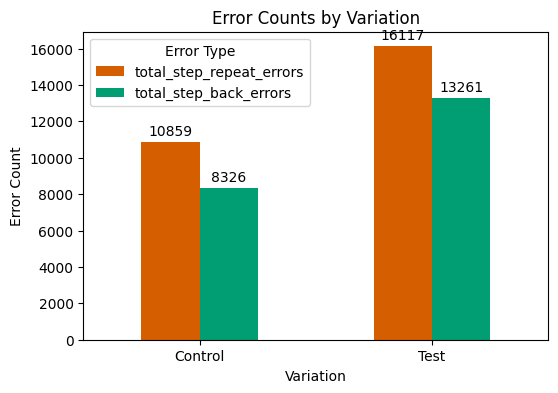

In [110]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6,4))

# Define custom colors (adjusting based on palette)
bars = error_summary.plot(kind='bar', color=[palette[3], palette[2]], ax=ax)

# Add labels to each bar
for container in bars.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10, color='black')

# Labels and title
ax.set_xlabel("Variation")
ax.set_ylabel("Error Count")
ax.set_title("Error Counts by Variation")
ax.set_xticklabels(error_summary['variation'], rotation=0)

ax.legend(title="Error Type")

plt.show()

The Test variation has over 50% more errors compared to the Control variation! 

Let's plot the average error rates per step, for each variation:

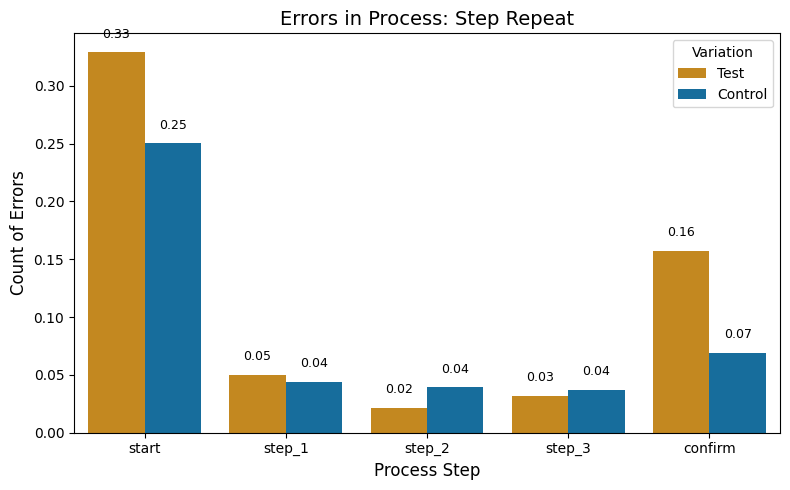

In [111]:
# Create a grouped bar plot comparing step repeat errors between the two variations
plt.figure(figsize=(8, 5))

sns.barplot(data=error_df, x='process_step', y='step_repeat_errors', hue='variation', ci=None, palette=[palette[1],palette[0]], order=process_step_order)

plt.title('Errors in Process: Step Repeat', fontsize=14)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Count of Errors', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Variation')

for bar in plt.gca().patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

**Comments:** 
- The high repeat rate for in the 'start' step of the Test variation suggests users may struggle to proceed from the starting step.

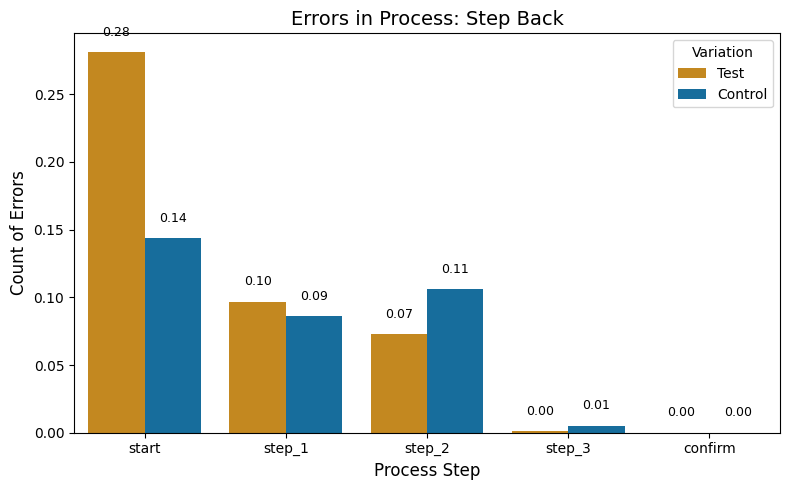

In [112]:
# Create a grouped bar plot comparing step back errors between the two variations
plt.figure(figsize=(8, 5))

sns.barplot(data=error_df, x='process_step', y='step_back_errors', hue='variation', ci=None, palette=[palette[1],palette[0]], order=process_step_order)

# Add titles and labels
plt.title('Errors in Process: Step Back', fontsize=14)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Count of Errors', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Variation')

# Add labels to the bars
for bar in plt.gca().patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

**Comments:**
- The Test variation generally has higher step back errors compared to the Control variation at the first step, but the errors drop in subsequent steps.

## 3.4. Drop off rate per step

Another metric I am going to use is that of "drop-off" rates, defined as a user abandoning the procedure prior to its completion. In this mertic, the 'confirm' step should have no counts, as reaching it signifies the completion of the process.

I'll start by defining a function to calculate the rates:

In [113]:
def count_visit_ids_per_process_step(df):
    # Define the process steps of interest
    df['process_step'] = pd.Categorical(df['process_step'], categories=process_step_order, ordered=True)

    # Group by 'variation' and 'process_step', and count unique 'visit_id'
    visit_counts = df.groupby(['variation', 'process_step'])['visit_id'].nunique().reset_index(name='visit_count')

    # Get the start counts for each variation
    start_counts = visit_counts[visit_counts['process_step'] == 'start'][['variation', 'visit_count']]
    start_counts.rename(columns={'visit_count': 'start_count'}, inplace=True)

    # Merge start counts back to visit_counts
    visit_counts = visit_counts.merge(start_counts, on='variation', how='left')

    # Calculate percentage and drop percentage
    visit_counts['percentage'] = (visit_counts['visit_count'] / visit_counts['start_count']) * 100
    visit_counts['drop_percentage'] = visit_counts.groupby('variation')['visit_count'].pct_change() * 100
    visit_counts.loc[visit_counts['process_step'] == 'start', 'drop_percentage'] = 0

    # Calculate total drop percentage for each variation
    total_drop = visit_counts[visit_counts['process_step'] == 'confirm'].copy()
    total_drop['drop_percentage'] = ((total_drop['visit_count'] / total_drop['start_count']) * 100 - 100).round(2)
    total_drop['process_step'] = 'total_drop'
    total_drop['visit_count'] = None
    total_drop['percentage'] = None

    # Append total_drop rows to visit_counts
    final_df = pd.concat([visit_counts, total_drop], ignore_index=True).reset_index(drop=True)

    # Round percentage and drop_percentage columns
    final_df['percentage'] = final_df['percentage'].round(2)
    final_df['drop_percentage'] = final_df['drop_percentage'].round(2)

    return final_df

And now let's have a look at the numbers calculated:

In [114]:
# Calculate abandonment stats
abandonment_stats = count_visit_ids_per_process_step(df_whole)

# Calculate drop-off rates
confirmed_visits = df_whole[df_whole['process_step'] == 'confirm']['visit_id'].unique()
df_whole['dropped_off'] = ~df_whole['visit_id'].isin(confirmed_visits)
dropoffs = df_whole[df_whole['dropped_off']].groupby(['process_step', 'variation'])['visit_id'].nunique().reset_index(name='drop_offs')
total_visits = df_whole.groupby(['process_step', 'variation'])['visit_id'].nunique().reset_index(name='total_visits')
dropoff_rates = pd.merge(dropoffs, total_visits, on=['process_step', 'variation'])
dropoff_rates['drop_off_rate'] = dropoff_rates['drop_offs'] / dropoff_rates['total_visits']

# Display results
print(dropoff_rates)

  process_step variation  drop_offs  total_visits  drop_off_rate
0        start   Control      15583         29611           0.53
1        start      Test      15169         31809           0.48
2       step_1   Control       8570         22712           0.38
3       step_1      Test      10301         27098           0.38
4       step_2   Control       5279         19468           0.27
5       step_2      Test       6502         23342           0.28
6       step_3   Control       3285         17637           0.19
7       step_3      Test       3933         20970           0.19
8      confirm   Control          0         15073           0.00
9      confirm      Test          0         20056           0.00


And plot them!

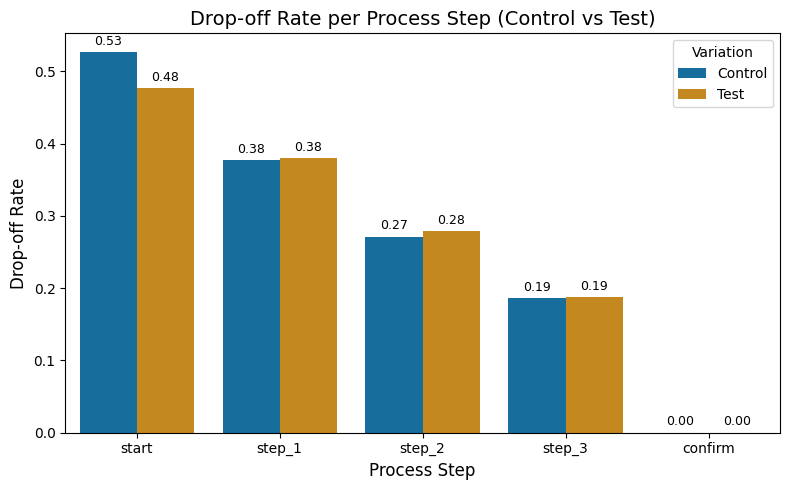

In [115]:
# Plot the drop-off rates
plt.figure(figsize=(8, 5))
sns.barplot(data=dropoff_rates, x='process_step', y='drop_off_rate', hue='variation', palette=palette)

# Add titles and labels
plt.title('Drop-off Rate per Process Step (Control vs Test)', fontsize=14)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('Drop-off Rate', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Variation')

# Add labels to the bars
for bar in plt.gca().patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.006, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

**Comments:** The two variations have similar drop-off rates; the control variation has a slight edge in the start step drop off.
It also makes sense that the confirm step has no drop off rates - reaching it signifies the valid end of the process.

# 4. A/B Hypothesis testing

We will now check the following hypotheses:

**1. Completion Rate**

- **Hypothesis:** Users in the test group will have a significantly higher completion rate compared to the control group.
- **Null Hypothesis:** There will be no significant difference in completion rates between the test and control groups.
<br>*Definition of Completion: Completing the final step, having first been through all the previous stages, i.e. start, step 1, step 2 and step 3.*

**2. Time Spent on Each Step**

- **Hypothesis:** Users in the test group will spend significantly less time on specific steps (or on the overall process) compared to the control group.
- **Null Hypothesis:** There will be no significant difference in the time spent on each step (or the overall process) between the test and control groups.

**3. Error Rates**

- **Hypothesis:** Users in the test group will experience significantly fewer errors (e.g., step back, step repeat) compared to the control group.
- **Null Hypothesis:** There will be no significant difference in error rates between the test and control groups.
<br>*Definition of Error Types: The types of errors we are measuring are step back, step repeat and invalid completions, i.e. without having gone through the required steps beforehand.*

**4. Drop-off Rate per Step**

- **Hypothesis:** Users in the test group will have a significantly lower drop-off rate at specific steps compared to the control group.
- **Null Hypothesis:** There will be no significant difference in drop-off rates at each step between the test and control groups.
Key Considerations:

We will use statistical tests to determine the statistical significance of the observed differences. We' ll start by assessing the nature of the variables in the hypotheses:rates

**1. Completion Rate**
<br>Completion rate is defined as completing the final step while having gone through all prior stages. This translates to either 1 (completed) or 0 (not completed) for each user. As it is assumes only two values, it cannot be normally distributed, so the statistical significance tests should be chosen accordingly.
<br>Nature: Binary/Boolean

**2. Time Spent on Each Step**
<br>Time spent on steps is measured in seconds. This is a continuous variable and may follow a normal distribution depending on the data. In that case, statistical tests such as t-tests might be appropriate.
<br>Nature: Continuous

**3. Error Rates**
<br>The error rates used ("step back" or "step repeat") are binary indicators: either an error occurred (1) or it didn't (0). While aggregate error rates might represent proportions, the individual occurrences are binary and not normally distributed.
<br>Nature: Binary/Boolean

**4. Drop-off Rate per Step**
<br>Drop-off rates are derived from whether a user dropped off at a specific step or continued. For each user, this is a binary outcome: 1 (dropped off) or 0 (did not drop off). This makes the variable non-normal at the user level.
<br>Nature: Binary/Boolean

## 4.1. Completion rates

- **Hypothesis:** Users in the test group will have a significantly higher completion rate compared to the control group.
- **Null Hypothesis:** There will be no significant difference in completion rates between the test and control groups.
<br>*Definition of Completion: Completing the final step, having first been through all the previous stages, i.e. start, step 1, step 2 and step 3.*

The total valid visit rates have already been calculated in Section 3.1 as follows:

In [116]:
print(f"Test Completion Rate: {p_test_validated:.2%}")
print(f"Test Completion Rate: {p_control_validated:.2%}")

Test Completion Rate: 46.60%
Test Completion Rate: 45.06%


### 4.1.1. Confidence Intervals calculation

What is the precision and variability of the total completion rates calculated? In other words, what is the range within which these rates are likely to fall?
<br>To assess this, we will use the normal approximation to construct confidence intervals for proportions. For each proportion we will calculate:


\begin{aligned}
\text{CI} & = \hat{p} \pm z \cdot \sqrt{\frac{\hat{p} \cdot (1 - \hat{p})}{n}} \\
\text{where:} & \\
\hat{p} & : \text{ Proportion} \\
n & : \text{ Total sample size for that group} \\
z & : \text{ Z-score corresponding to the desired confidence level} \\
\end{aligned}

We will also check the Confidence Intervals for the Differences between the two rates:

$$
\text{Proportion Difference: } \\
\Delta = \hat{p}_{\text{test}} - \hat{p}_{\text{control}}
$$

$$
\text{Standard Error of the Difference: } \\
SE_{\Delta} = \sqrt{\frac{\hat{p}_{\text{test}} \cdot (1 - \hat{p}_{\text{test}})}{n_{\text{test}}} + \frac{\hat{p}_{\text{control}} \cdot (1 - \hat{p}_{\text{control}})}{n_{\text{control}}}}
$$

$$
\text{Confidence Interval: } \\
\text{CI} = \Delta \pm z \cdot SE_{\Delta}
$$


In a two-tailed 95% confidence interval (CI), the central 95% of the data is retained, meaning 2.5% is in the lower tail and 2.5% is in the upper tail.

In [118]:
# norm.ppf(0.975) gives the z-score corresponding to the 97.5th percentile of the standard normal distribution 
# Confidence level (95%)
z = norm.ppf(0.975)  # Two-tailed 95% CI 

# Confidence interval for Test group
se_test = (p_test_validated * (1 - p_test_validated) / n_test_total) ** 0.5
ci_test = (p_test_validated - z * se_test, p_test_validated + z * se_test)

# Confidence interval for Control group
se_control = (p_control_validated * (1 - p_control_validated) / n_control_total) ** 0.5
ci_control = (p_control_validated - z * se_control, p_control_validated + z * se_control)

# Difference in proportions
p_diff = p_test_validated - p_control_validated
se_diff = ((p_test_validated * (1 - p_test_validated) / n_test_total) + (p_control_validated * (1 - p_control_validated) / n_control_total)) ** 0.5
ci_diff = (p_diff - z * se_diff, p_diff + z * se_diff)

# Print results
print(f"Test Completion Rate: {p_test_validated:.2%}, Confidence Interval: ({ci_test[0]:.2%}, {ci_test[1]:.2%})")
print(f"Control Completion Rate: {p_control_validated:.2%}, Confidence Interval: ({ci_control[0]:.2%}, {ci_control[1]:.2%})")
print(f"Difference in Completion Rates: {p_diff:.2%}, Confidence Interval: ({ci_diff[0]:.2%}, {ci_diff[1]:.2%})")

Test Completion Rate: 46.60%, Confidence Interval: (46.08%, 47.12%)
Control Completion Rate: 45.06%, Confidence Interval: (44.51%, 45.62%)
Difference in Completion Rates: 1.53%, Confidence Interval: (0.77%, 2.29%)


And now let's plot total completion rates including CI:

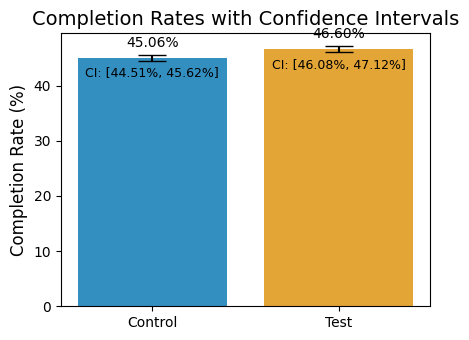

In [126]:
# Calculate completion rates as percentages
completion_rates = [p_control_validated * 100, p_test_validated * 100]  # Convert proportions to percentages
confidence_intervals = [
    (ci_control[1] - ci_control[0]) * 100 / 2,  # Half-width of CI in percentage
    (ci_test[1] - ci_test[0]) * 100 / 2
]

# CI bounds
ci_lower = [completion_rates[0] - confidence_intervals[0], completion_rates[1] - confidence_intervals[1]]
ci_upper = [completion_rates[0] + confidence_intervals[0], completion_rates[1] + confidence_intervals[1]]

# Define labels 
labels = ["Control", "Test"]

fig, ax = plt.subplots(figsize=(4.5, 3.5))

bars = ax.bar(labels, completion_rates, yerr=confidence_intervals, capsize=10, color=[palette[0], palette[1]], alpha=0.8)

# Annotate the completion rates and confidence intervals
for i, bar in enumerate(bars):
    # Annotate the completion rate
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, 
             f"{completion_rates[i]:.2f}%", ha='center', fontsize=10)
    # Annotate the confidence interval
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - confidence_intervals[i] - 3,
             f"CI: [{ci_lower[i]:.2f}%, {ci_upper[i]:.2f}%]", ha='center', fontsize=9, color='black')

# Formatting plot
ax.set_title("Completion Rates with Confidence Intervals", fontsize=14)
ax.set_ylabel("Completion Rate (%)", fontsize=12)

plt.tight_layout()
plt.show()

**Comments**

**Test Group:** 
The completion rate for the test group is 46.60%, with a 95% confidence interval of (46.08%, 47.12%). This means we are 95% confident that the true completion rate for the test group lies within this range. 

**Control Group:** 
The completion rate for the control group is 45.06%, with a 95% confidence interval of (44.51%, 45.62%). 

**Difference in Rates:** 
The difference in completion rates between the test and control groups is 1.53%, with a confidence interval of (0.77%, 2.29%). Since this range does not include zero, the result is statistically significant, further confirming the higher completion rate in the test group.

### 4.1.2. Overall Completion Rates

#### 4.1.2.1. Statistical significance

Since we’re comparing two proportions, we can also perform a Chi-Square Test to compare the completion rates between the test and control groups. The Chi-Square Test evaluates whether two categorical variables are independent or associated. In our context:

- Categorical Variable 1: The variation (Test vs. Control).
- Categorical Variable 2: Whether the visit is "completed", including all intermediate steps.

The test will help to determine whether the variation (Test vs. Control) influences the likelihood of completion: a higher chi-square statistic will indicate a greater difference between what was observed and what was expected under the null hypothesis.

In [128]:
# Observed counts
observed = np.array([[n_test_validated, n_test_total - n_test_validated], 
                     [n_control_validated, n_control_total - n_control_validated]])

# Perform Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(observed)

print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in total completion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in total completion rates.")

Chi-Square Statistic: 15.5700
P-value: 0.0001
Reject the null hypothesis: There is a significant difference in total completion rates.


- The resulting χ²=15.57 value quantifies how much the observed counts in the contingency table deviate from the expected counts under the null hypothesis (no difference between Test and Control).
Larger values of χ² indicate stronger evidence against the null hypothesis.
- P-Value (p=0.0001): This is the probability of observing a Chi-Square statistic as extreme as 15.57 (or more) if the null hypothesis is true. Since p < 0.05 we reject the null hypothesis. This means the observed difference between Test and Control is unlikely to be due to random chance and is statistically significant.

#### Conclusions

- The test group has a significantly higher overall completion rate than the control group. The Chi-Square test confirms that this difference is statistically significant.

### 4.1.3. Individual steps completion rates analysis

We also want to compare the proportion of valid completions (valid_confirm) at each step between the Test and Control groups.

#### 4.1.3.1. Statistical significance

<br>While the chi-square test is appropriate when comparing overall step distributions, with multiple proportions at once (e.g., overall step distributions), for comparing proportions at each step individually we will use a Two-Proportion Z-Test. 

- The Z-statistic is a measure of how far a sample statistic (e.g., conversion rate or proportion at each process step) deviates from the expected value under the **null hypothesis** (i.e. no difference between the two variations), measured in standard deviations.
- The p-value helps determine whether this deviation is statistically significant.

The raw data (0 and 1) is not normal, but the distribution of the sample proportions can be approximated as normal if the sample size is sufficiently large, which is our case.

In [131]:
# Initialize a list to store z-test results
z_test_results = []

# Loop through each step to compare proportions between variations
for step in process_step_order:
    # Filter the data to include visits that have completed the current step
    df_step = df_whole[df_whole['process_step'] == step].copy()

    # Identify completed steps (steps followed by the next step in the same visit_id)
    if step != 'confirm':  # Skip for the last step
        df_step['completed'] = df_step['visit_id'].isin(
            df_whole[df_whole['process_step'].isin(process_step_order[process_step_order.index(step) + 1:])]['visit_id']
        ).astype(int)
    else:
        df_step['completed'] = 0  # No subsequent steps to check for completion

    # Calculate counts of completed steps for Test and Control
    count_control = df_step[(df_step['variation'] == 'Control') & (df_step['completed'] == 1)].shape[0]
    count_test = df_step[(df_step['variation'] == 'Test') & (df_step['completed'] == 1)].shape[0]

    # Calculate total visits for Test and Control
    nobs_control = df_step[df_step['variation'] == 'Control'].shape[0]
    nobs_test = df_step[df_step['variation'] == 'Test'].shape[0]

    # Perform Z-Test if valid data exists
    if (count_test + count_control) > 0 and (nobs_test > 0 and nobs_control > 0):
        stat, pval = proportions_ztest([count_control, count_test], [nobs_control, nobs_test])  
    else:
        stat, pval = float('nan'), float('nan')  # Assign NaN if invalid input

    # Append the results
    z_test_results.append({
        'Process Step': step,
        'Z-Statistic': stat,
        'p-value': pval
    })

# Convert the results to a DataFrame
z_test_df_completion_rates = pd.DataFrame(z_test_results)

# Ensure the correct ordering of steps
z_test_df_completion_rates['Process Step'] = pd.Categorical(z_test_df_completion_rates['Process Step'], categories=process_step_order, ordered=True)
z_test_df_completion_rates = z_test_df_completion_rates.sort_values('Process Step')

# Print the results
print(z_test_df_completion_rates)

  Process Step  Z-Statistic  p-value
0        start       -32.54     0.00
1       step_1        -2.05     0.04
2       step_2         8.48     0.00
3       step_3         1.95     0.05
4      confirm          NaN      NaN


**Comments:**

* **p-value < 0.05:** Indicates a statistically significant difference in the distributions of `valid_confirm` between the test and control groups.
* **p-value >= 0.05:** Suggests no significant difference for that step.

* **|Z| > 1.96:** Statistically significant at 5% level (α = 0.05)

- A negative Z-statistic means that the proportion of completions in the Test group is lower than the Control group for that specific process step.
- "start" and "step_2" show the most significant deviations from the null hypothesis, i.e. the two variation completion rates differ significantly on those steps.
- "step_1" and "step_3" have borderline significance, meaning deviations exist but are weaker.

Let's plot the p-value and Z-statistics results to better understand them:

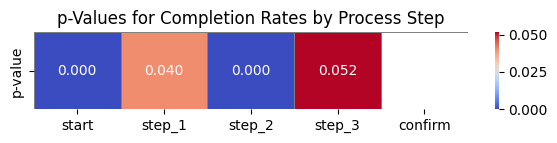

In [139]:
# Plot p-values
heatmap_data_pvalues = z_test_df_completion_rates.set_index('Process Step')[['p-value']].T 

# Create figure and axes for subplots
fig = plt.figure(figsize=(7, 1))  

# create a heatmap for the P-values
sns.heatmap(
    heatmap_data_pvalues, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.3f',  
    linewidths=0.5,  
    linecolor='gray',  
    # cbar_kws={'label': 'p-value'}, 
)
plt.title('p-Values for Completion Rates by Process Step')
plt.xlabel('')
# plt.ylabel('p-value')
plt.tick_params(axis='x', rotation=0)  # Keep x labels readable

plt.show()

Let's also check the Z-Statistic:

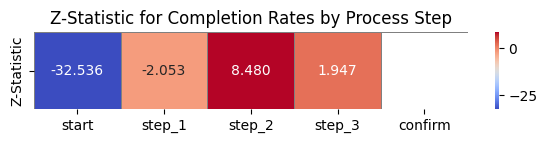

In [137]:
# Plot Z-Statistic
heatmap_data_zscores = z_test_df_completion_rates.set_index('Process Step')[['Z-Statistic']].T  # Z-scores

fig = plt.figure(figsize=(7, 1))  

sns.heatmap(
    heatmap_data_zscores, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.3f',  
    linewidths=0.5,  
    linecolor='gray',  
    # cbar_kws={'label': 'z-statistic'}, 
)
plt.title('Z-Statistic for Completion Rates by Process Step')
plt.xlabel('')
# plt.ylabel('z-statistic')
plt.tick_params(axis='x', rotation=0)  

plt.show()

Therefore, in start and step 2 - where the z-value is much greater than 1.96 and less than -1.96 respectively - the observed result is unlikely to occur under the null hypothesis.

#### 4.1.3.2. Effect size

While p-values tell us whether an effect is statistically significant, they do not indicate how practically meaningful that effect is. Effect size helps determine the magnitude of the difference, providing a clearer understanding of its impact.

*In general, small effects can be statistically significant but not practically significant, while medium/large effects are more meaningful in decision-making.*

As we are measuring proportions (completion rates), Cohen’s h is the preferred effect size measure:

\begin{aligned}
h &= 2 \times \arcsin(\sqrt{p_{test}}) - 2 \times \arcsin(\sqrt{p_{control}}) \\
\text{where:} \\
h &: \text{ Cohen’s h} \\
p_{test} &: \text{ Proportion in the test group} \\
p_{control} &: \text{ Proportion in the control group} 
\end{aligned}

General Interpretation of Cohen's h (Effect Size):

| Cohen's h | Effect Size Interpretation |
|---|---|
| 0.01 - 0.20 | Small effect (Minimal difference) |
| 0.20 - 0.50 | Medium effect (Moderate difference) |
| 0.50+ | Large effect (Strong difference) |

In [143]:
# Function to compute Cohen's h
def cohen_h(p1, p2):
    """Calculate Cohen's h for two proportions."""
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Initialize a list to store Cohen’s h results
cohen_h_results = []

# Loop through each step and compute Cohen's h using precomputed completion rates
for step in [s for s in process_step_order if s != 'confirm']:
    # Get completion rates from the precomputed dictionary
    p_test_step = completion_rates_variation['Test'][step]
    p_control_step = completion_rates_variation['Control'][step]

    # Compute Cohen's h if valid proportions exist
    h_step = cohen_h(p_test_step, p_control_step) if not np.isnan(p_test_step) and not np.isnan(p_control_step) else np.nan

    # Append the results
    cohen_h_results.append({
        'Process Step': step,
        'Cohen\'s h': h_step,
        'Test Completion Rate': p_test_step,
        'Control Completion Rate': p_control_step
    })

# Convert the results to a DataFrame
cohen_h_df_steps = pd.DataFrame(cohen_h_results)

# Ensure the correct ordering of steps
cohen_h_df_steps['Process Step'] = pd.Categorical(cohen_h_df_steps['Process Step'], categories=process_step_order, ordered=True)
cohen_h_df_steps = cohen_h_df_steps.sort_values('Process Step')

print(cohen_h_df_steps)

  Process Step  Cohen's h  Test Completion Rate  Control Completion Rate
0        start      -0.25                  0.90                     0.96
1       step_1       0.06                  0.75                     0.73
2       step_2       0.05                  0.64                     0.62
3       step_3       0.04                  0.57                     0.55


**Conclusions:**

| Process Step | Completion Rate Result | Significance Interpretation | Effect Size Interpretation |
| :--- | :--- | :--- | :--- | 
| start | The Control group has a higher completion rate (96%) than the Test group (90%) | Highly significant difference: the Test group is significantly worse at progressing past the start step | It has a moderate practical effect |
| step_1 | Test variation has a slightly higher completion rate than the Control one | The difference is small but real and statistically significant | The actual effect size is negligible. This means that in practice, the improvement may not be meaningful |
| step_2 | Test has a slightly higher completion rate than Control | Significant difference: the Test performs significantly better than Control | Very small effect |
| step_3 | Test has a slightly higher completion rate than Control | The difference in completion rates is not statistically significant. | Very small effect | 

Overall, the test group performs worst in terms of completion rates at the starting step but slightly better in the remaining steps. However, the practical effect of these differences is small.

## 4.2. Time Spent on Each Step

We will now compare the average time spent on each step between the test and control groups:
- **Hypothesis:** Users in the test group will spend significantly less time on specific steps (or on the overall process) compared to the control group.
- **Null Hypothesis:** There will be no significant difference in the time spent on each step (or the overall process) between the test and control groups.

Prior to testing the significance in the step-level time differences between the two variations, we need to establish whether the data follows a normal distribution. This is required in order to choose an appropriate siginifcance test because e.g. the t-test assumes normality of the data in each group. If this assumption is violated, the results of the t-test might not be reliable.

Given that our sample size for each step is large (close to 20,000), running the Shapiro-Wilk test for normality is not suitable. We will use Quantile-Quantile Plots to check for normality:

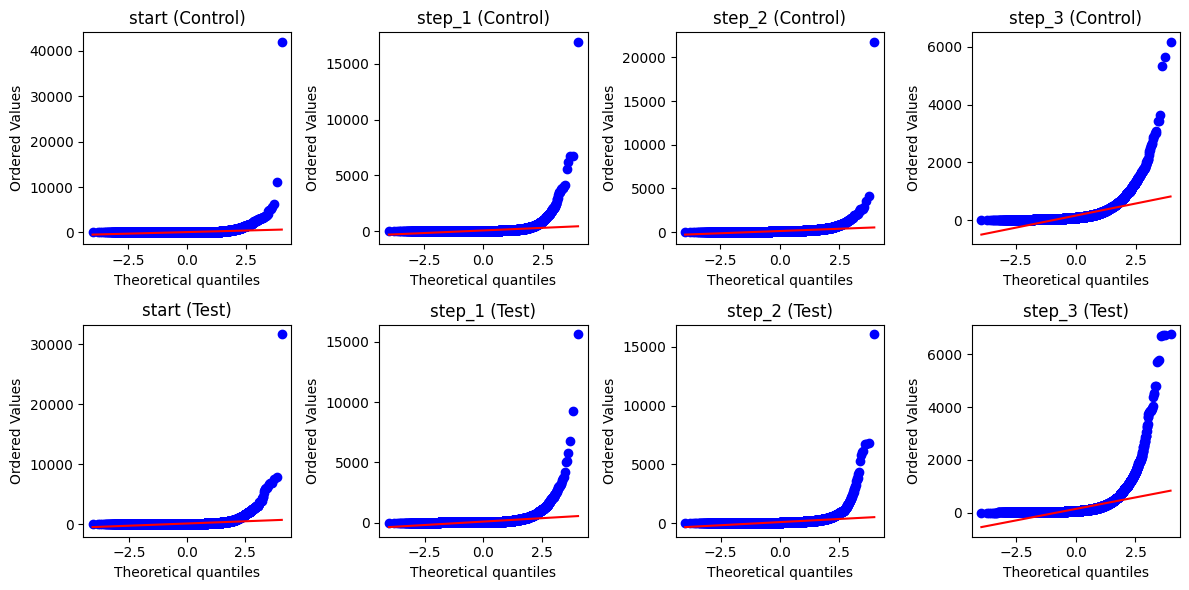

In [144]:
# Exclude the 'confirm' step 
filtered_steps = [step for step in process_step_order if step != 'confirm']

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows (Control & Test), 4 columns (one per step)

for col, step in enumerate(filtered_steps):
    for row, variation in enumerate(['Control', 'Test']):
        # Filter data
        step_data = time_long[(time_long['process_step'] == step) & (time_long['variation'] == variation)]['time']
        
        # Q-Q Plot 
        probplot(step_data, dist="norm", plot=axes[row, col])  
        axes[row, col].set_title(f"{step} ({variation})")

plt.tight_layout()
plt.show()

The points follow a nonlinear pattern, suggesting that the data are not distributed as a standard normal. We will therefore use a non-parametric test (the *Mann-Whitney U test*) to compare time differences between the test and control groups. Non-parametric tests do not require normality.

In [145]:
# List to store Mann-Whitney U test results
mann_whitney_results = []

# Loop through each process step
for step in time_long['process_step'].unique():
    # Filter data for the current step
    step_data = time_long[time_long['process_step'] == step]
    
    # Separate times for test and control groups
    test_times = step_data[step_data['variation'] == 'Test']['time']
    control_times = step_data[step_data['variation'] == 'Control']['time']
    
    # Perform Mann-Whitney U test
    if len(test_times) > 0 and len(control_times) > 0:
        stat, pval = mannwhitneyu(test_times, control_times, alternative='two-sided')  # Two-sided test
    else:
        stat, pval = float('nan'), float('nan')  # Handle cases with insufficient data
    
    # Append results
    mann_whitney_results.append({
        'Process Step': step,
        'U-Statistic': stat,
        'P-Value': pval
    })

# Convert results to DataFrame
mann_whitney_df = pd.DataFrame(mann_whitney_results)

# Display the results
print(mann_whitney_df)

  Process Step  U-Statistic  P-Value
0        start 314088948.50     0.00
1       step_1 297505605.50     0.00
2       step_2 187008680.00     0.00
3       step_3 124730529.00     0.00


- The calculated P-Values below 0.05 show that there is a statistically significant difference between Test and Control in the time spent on all steps.
- The Mann-Whitney U test measures how much the rank distributions of the two groups overlap. Greater U means smaller difference.

These results tell us that a small but significant difference exists; however, they do not measure how meaningful the difference is.

To measure the effect size, we will use the Rank-Biserial Correlation (RBC):

\begin{aligned}
RBC &= 1 - \frac{2U}{n_1 n_2} \\
\text{where:} \\
RBC &: \text{ Rank-Biserial Correlation} \\
U &: \text{ Mann-Whitney U statistic} \\
n_1 &: \text{ Sample size of group 1} \\
n_2 &: \text{ Sample size of group 2} 
\end{aligned}

Where depending on the calculated RBC, we have:
* |RBC| < 0.1 → Small effect
* |RBC| ~ 0.3 → Medium effect
* |RBC| > 0.5 → Large effect

- A positive RBC will mean that the Test group has systematically higher values than the Control group. In this case (time spent per process step), this would mean Test users take longer than Control users, at that step.
- A negative RBC means that the Test group has systematically lower values than the Control group, i.e. users complete that step faster than the Control group.

In [146]:
# Function to compute Rank-Biserial Correlation
def rank_biserial_correlation(u_stat, n1, n2):
    return 1 - (2 * u_stat) / (n1 * n2)

# List to store effect sizes
effect_sizes = []

# Loop through each process step and use the U-statistics calculated above
for index, row in mann_whitney_df.iterrows():
    step = row['Process Step']
    
    # Retrieve sample sizes
    test_n = time_long[(time_long['process_step'] == step) & (time_long['variation'] == 'Test')].shape[0]
    control_n = time_long[(time_long['process_step'] == step) & (time_long['variation'] == 'Control')].shape[0]
    
    # Compute Rank-Biserial Correlation
    if test_n > 0 and control_n > 0:
        rbc = rank_biserial_correlation(row['U-Statistic'], test_n, control_n)
    else:
        rbc = float('nan')  # Handle cases with insufficient data

    # Append results
    effect_sizes.append({'Process Step': step, 'Rank-Biserial Correlation': rbc})

# Convert to DataFrame
effect_size_df = pd.DataFrame(effect_sizes)

# Merge with Mann-Whitney results
mann_whitney_results_df = mann_whitney_df.merge(effect_size_df, on='Process Step')

# Display results
print(mann_whitney_results_df)

  Process Step  U-Statistic  P-Value  Rank-Biserial Correlation
0        start 314088948.50     0.00                       0.11
1       step_1 297505605.50     0.00                      -0.18
2       step_2 187008680.00     0.00                       0.07
3       step_3 124730529.00     0.00                       0.20


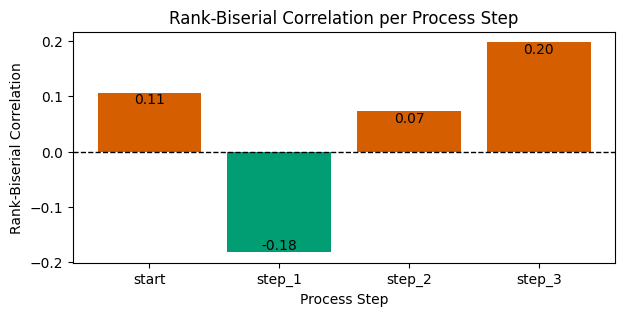

In [147]:
# Data for Rank-Biserial Correlation
rank_biserial_corr = mann_whitney_results_df['Rank-Biserial Correlation']

# Create the bar chart
plt.figure(figsize=(7, 3))
bars = plt.bar(mann_whitney_results_df['Process Step'], mann_whitney_results_df['Rank-Biserial Correlation'], color=[palette[3] if x > 0 else palette[2] for x in rank_biserial_corr])

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Process Step")
plt.ylabel("Rank-Biserial Correlation")
plt.title("Rank-Biserial Correlation per Process Step")

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", 
             ha='center', va='bottom' if yval < 0 else 'top', fontsize=10)

# Show the plot
plt.show()

How do we explain that in some steps the mean times suggest one trend, but the Rank-Biserial Correlation (RBC) suggests another (steps 1, 2 and 3)?
- The Rank-Biserial Correlation is based on the ranking of values, not just means. If the Test Variation has a lower median but a few extreme outliers pushing the mean up, it could still show a positive correlation while having a slightly higher mean. So means that the mean time alone is **misleading** for those specific steps.

| Process Step | Test Mean Time | Control Mean Time | Test Faster or Slower (Mean Time)? | RBC Value | RBC Interpretation (Ranks) | Do Mean & RBC Agree? |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Start | 88.81 sec | 85.57 sec | Test is slower | 0.11 | Test is slower | Yes, they agree |
| Step 1 | 83.02 sec | 63.41 sec | Test is slower | -0.18 | Test is faster | Contradiction |
| Step 2 | 110.26 sec | 116.84 sec | Test is faster | 0.07 | Test is slower | Contradiction |
| Step 3 | 138.65 sec | 158.66 sec | Test is faster | 0.20 | Test is slower | Contradiction |

To find out what the cause is, I will examine the percentiles for each step:

In [149]:
time_long.groupby(['process_step', 'variation'])['time'].describe()

count   mean    std  min   25%   50%    75%      max
process_step variation                                                        
start        Control   24551.00  85.57 360.83 1.00 12.00 25.00  59.00 41957.00
             Test      28634.00  88.81 330.57 1.00  9.00 17.00  68.00 31624.00
step_1       Control   20288.00  63.41 221.90 1.00 11.00 25.00  56.00 16950.00
             Test      24814.00  83.02 223.07 0.00 18.00 34.00  70.00 15620.00
step_2       Control   18204.00 116.84 212.45 1.00 51.00 82.00 135.00 21763.00
             Test      22177.00 110.26 214.56 0.00 47.00 74.00 120.00 16036.00
step_3       Control   15966.00 158.66 234.41 1.00 49.00 87.00 170.00  6164.00
             Test      19474.00 138.65 283.04 0.00 33.00 60.00 131.00  6760.00

Indeed, the higher 75% values in the Test variation in step 1 indicates that outliers are likely skewing the mean computed, while the opposite is true in steps 2 and 3. 

**Comments:**

| Process Step | Statistical Significance | Effect Size |
| :--- | :--- | :--- | 
| Start | A significant portion of users take much longer in the Test variation than in Control, and a statistically significant difference exists. | A small positive Rank-Biserial correlation suggests the effect is small. |
| Step 1 | Most users in Test complete Step 1 faster, but a subset of users take significantly longer. The mean is skewed by a few very slow users in Test. | The Rank-Biserial correlation indicates a small to medium effect. |
| Step 2 | Test is faster by median and mean times, but RBC suggests the opposite. Even though most Test users are faster, some take much longer - and the difference is statistically significant. | A small positive Rank-Biserial correlation indicates users in the Test Variation take slightly longer to complete step 2. |
| Step 3 | Median and mean confirm that Test is faster, but RBC suggests Test is slower. This means that while most Test users are faster, some take significantly longer. | A small to medium positive Rank-Biserial correlation indicates users in the Test Variation take longer to complete step 3. |

The recommendation following these results would be to examine if there are UI problems, or confusion affecting only certain users.

## 4.3. Error Rates

- **Hypothesis:** Users in the test group will experience significantly fewer errors (e.g., step back, step repeat) compared to the control group.
- **Null Hypothesis:** There will be no significant difference in error rates between the test and control groups.
<br>*Definition of Error Types: The types of errors we are measuring are step back, step repeat and invalid completions, i.e. without having gone through the required steps beforehand.*

In this section, we will examine the significance and effect of the difference in "error back" and "step repeat" errors, as those were calculated in [Section 3.3](#errorRatesCalcs). As in the previous case, the steps we will follow are:
1. Examine the distribution of the data
2. Calculate the significance of the difference in error rates between the variations
3. Calculate the effect of the significance differences

Since our data consists of binary values (e.g., 0 = no step back, 1 = step back), the assumptions of a t-test are violated because:
<br>a) The t-test assumes continuous data and 
<br>b) It also assumes the data follows a roughly normal distribution, which binary data does not.

Therefore, to check the significance of the difference between the two variations, we will use the Mann-Whitney U test, which is a non-parametric test (meaning it does not require the data to follow a normal distribution). For the effect size, we will use the Rank-Biseral correlation, which evaluates results as follows:

* Small effect: ~0.1
* Medium effect: ~0.3
* Large effect: ~0.5

### 4.3.1. Step back count errors

In [150]:
error_df.head()

,visit_id,process_step,variation,step_repeat_errors,step_back_errors
0,100012776_37918976071_457913,confirm,Test,1,0
1,100019538_17884295066_43909,start,Test,0,0
2,100019538_17884295066_43909,step_3,Test,0,0
3,100022086_87870757897_149620,confirm,Test,0,0
4,100022086_87870757897_149620,start,Test,0,0


In [152]:
# Initialize an empty list to store results
results = []

# Loop through each process step and perform the Mann-Whitney U test
for step in process_step_order:
    # Filter data for the current process step
    step_data = df_whole[df_whole['process_step'] == step]
    
    # Split into Test and Control groups for step_back_count
    test_group = step_data[step_data['variation'] == 'Test']['step_back_error']
    control_group = step_data[step_data['variation'] == 'Control']['step_back_error']
    
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(test_group, control_group, alternative='two-sided')
    
    # Calculate effect size (Rank-Biserial Correlation)
    n1 = len(test_group)
    n2 = len(control_group)
    effect_size = (2 * stat) / (n1 * n2) - 1
    
    # Add results as a dictionary to the list
    results.append({
        'Process Step': step,
        'U-Statistic': stat,
        'P-Value': p_value,
        'Effect Size': effect_size
    })

# Convert the list of results into a DataFrame
step_back_error_results_df = pd.DataFrame(results)

print(step_back_error_results_df)

  Process Step   U-Statistic  P-Value  Effect Size
0        start 1119222175.50     0.00         0.07
1       step_1  493655367.00     0.07         0.00
2       step_2  331254102.00     0.00        -0.02
3       step_3  245988807.50     0.00        -0.00
4      confirm  188073637.50     1.00         0.00


We therefore conclude the following:

| Process Step | Statistical Significance | Effect Size |
| :--- | :--- | :--- |
| Start | Highly significant difference - More step back errors in Test group. | Small effect. |
| Step 1 | Marginally significant difference - No major variation impact. | No meaningful effect - Similar errors in both groups. |
| Step 2 | Highly significant difference - The Control variation performs better at Step 2. | Small effect. |
| Step 3 | Highly significant difference but practically irrelevant. | No meaningful effect - Difference is statistically significant but negligible. |

### 4.3.2. Step repeat count errors

Let's now check the significance of the errors noted in the step repeat errors, between the variations:

In [153]:
# Initialize an empty list to store results
results = []

# Loop through each process step and perform the Mann-Whitney U test
for step in process_step_order:
    # Filter data for the current process step
    step_data = df_whole[df_whole['process_step'] == step]
    
    # Split into Test and Control groups for step_back_count
    test_group = step_data[step_data['variation'] == 'Test']['step_repeat_error']
    control_group = step_data[step_data['variation'] == 'Control']['step_repeat_error']
    
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(test_group, control_group, alternative='two-sided')
    
    # Calculate effect size (Rank-Biserial Correlation)
    n1 = len(test_group)
    n2 = len(control_group)
    effect_size = (2 * stat) / (n1 * n2) - 1
    
    # Add results as a dictionary to the list
    results.append({
        'Process Step': step,
        'U-Statistic': stat,
        'P-Value': p_value,
        'Effect Size': effect_size
    })

# Convert the list of results into a DataFrame
step_repeat_error_results_df = pd.DataFrame(results)

print(step_repeat_error_results_df)

  Process Step   U-Statistic  P-Value  Effect Size
0        start 1070502010.50     0.00         0.02
1       step_1  492656959.50     0.24         0.00
2       step_2  334873678.00     0.00        -0.01
3       step_3  246190651.00     0.11        -0.00
4      confirm  201432293.00     0.00         0.07


For the step repeat errors we conclude that:

| Process Step | Statistical Significance | Effect Size |
| :--- | :--- | :--- |
| Start | Highly significant difference - Test users repeat steps more often than Control users. | Small effect. |
| Step 1 | No significant difference. | No meaningful effect - Similar step repeat errors in both groups. |
| Step 2 | Highly significant difference - Control users repeat steps slightly more often. | Small effect - The Test group has slightly fewer step repeat errors. |
| Step 3 | No significant difference. | No meaningful effect - Difference is statistically marginal but practically negligible. |
| Confirm | Highly significant difference - Test users repeat more often the confirmation step. | Small effect. |

## 4.4. Drop-off rates

- **Hypothesis:** Users in the test group will have a significantly lower drop-off rate at specific steps compared to the control group.
- **Null Hypothesis:** There will be no significant difference in drop-off rates at each step between the test and control groups.

The initial dropped_off values are binary (True/False), which means they do not follow a continuous distribution. A t-test is therefore not suitable, as it assumes the data being compared are continuous and approximately normally distributed. We will use a Chi-Square Test instead, to examine whether there is a significant association between variation (Test vs. Control) and drop-off status (True vs. False) at each process step. The Chi-Square Test is suitable for categorical data like this.

In [154]:
# Initialize a dictionary to store results
chi_square_results_drop_off = {'Process Step': [], 'P-Value': []}

# Loop through each process step
for step in dropoff_rates['process_step'].unique():
    # Filter data for the current step
    step_data = df_whole[df_whole['process_step'] == step]
    
    # Create a contingency table
    contingency_table = pd.crosstab(step_data['variation'], step_data['dropped_off'])
    
    # Perform Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Append results
    chi_square_results_drop_off['Process Step'].append(step)
    chi_square_results_drop_off['P-Value'].append(p_value)

# Convert results to a DataFrame
chi_square_df_drop_off = pd.DataFrame(chi_square_results_drop_off)

print(chi_square_df_drop_off)

  Process Step  P-Value
0        start     0.00
1       step_1     0.01
2       step_2     0.00
3       step_3     0.05
4      confirm     1.00


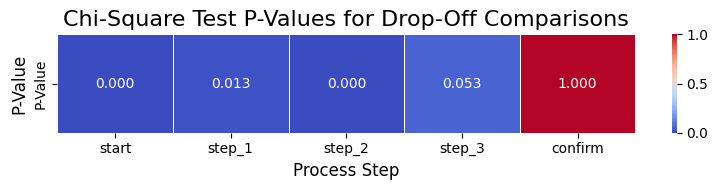

In [156]:
# Prepare data for heatmap
heatmap_data = chi_square_df_drop_off.set_index('Process Step').T

plt.figure(figsize=(8, 2))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    linewidths=0.5,
    # cbar_kws={'label': 'P-Value'}
)
plt.title('Chi-Square Test P-Values for Drop-Off Comparisons', fontsize=16)
plt.xlabel('Process Step', fontsize=12)
plt.ylabel('P-Value', fontsize=12)
plt.tight_layout()
plt.show()

Effect Size for the Drop-Off Rates Analysis: Since we are using a Chi-Square Test to evaluate the relationship between variation (Test vs. Control) and drop-off status (True vs. False), an effect metric we can use is Cramér’s V:

\begin{aligned}
V &= \sqrt{\frac{\chi^2}{n(k-1)}} \\
\text{where:} \\
V &: \text{ Cramer's V} \\
\chi^2 &: \text{ Chi-Square statistic} \\
n &: \text{ Total sample size} \\
k &: \text{ The smaller of (number of rows or columns) in the contingency table}
\end{aligned}

* **Interpretation:**

    * 0.1 → Small effect
    * 0.3 → Medium effect
    * 0.5+ → Large effect

In [157]:
# Initialize a list to store effect size results
cramers_v_results = []

# Loop through each process step
for step in chi_square_df_drop_off['Process Step']:
    # Filter data for the current step
    step_data = df_whole[df_whole['process_step'] == step]

    # Create a contingency table
    contingency_table = pd.crosstab(step_data['variation'], step_data['dropped_off'])

    # Perform Chi-Square test
    chi2, _, _, _ = chi2_contingency(contingency_table)

    # Compute sample size (n) and Cramér’s V
    n = contingency_table.to_numpy().sum()
    k = min(contingency_table.shape)
    cramers_v = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else 0  # Avoid division by zero

    # Append results
    cramers_v_results.append({'Process Step': step, 'Effect Size (Cramér’s V)': cramers_v})

# Convert results to a DataFrame
cramers_v_df = pd.DataFrame(cramers_v_results)

# Merge with existing Chi-Square results
chi_square_df_drop_off = chi_square_df_drop_off.merge(cramers_v_df, on='Process Step')

print(chi_square_df_drop_off)

  Process Step  P-Value  Effect Size (Cramér’s V)
0        start     0.00                      0.02
1       step_1     0.01                      0.01
2       step_2     0.00                      0.03
3       step_3     0.05                      0.01
4      confirm     1.00                      0.00


For the drop off rate differences per step between the two variations we can see that:

| Process Step | Statistical Significance | Effect Size Interpretation |
| :--- | :--- | :--- |
| start | Highly significant difference - The Test variation has lower drop-off rates than the Control one at the start. | Small effect. |
| step_1 | Significant difference - but almost negligible rate difference. | Very small effect - Minimal difference in drop-off behavior. |
| step_2 | Highly significant difference. | Small effect. |
| step_3 | Marginally significant difference. | Very small effect - Statistically significant but practically negligible. |

# 5. Conclusions

The main question of this A/B test is to address through the coducted analysis the user experience of the new interface, its effectiveness, and whether it will enhance user experience and completion rates for clients.

**Conclusions**

The A/B test results indicate that the Test variation led to a statistically significant increase in completion rates compared to the Control group, with a 1.53% absolute improvement (46.60% vs. 45.06%), confirming the primary hypothesis. Completion rates across subsequent steps were similar between the two variations. An analysis of individual steps shows that the Test group experienced a higher drop-off at the start step (Cohen’s h = -0.25), suggesting initial friction. In terms of time spent per step, the Test group generally moved faster through step 2 and step 3, but had a higher average time in step 1, indicating some inconsistencies in user experience. Error rates (step backs and step repeats) were largely comparable between variations, except for a slight increase in step back errors at the start step for the Test group, reinforcing potential friction in onboarding.

**Recommendations**

To further optimize the Test variation, efforts should be made to reduce friction at the start step, as indicated by higher drop-off rates and step back errors. Investigating user behavior (e.g., session recordings, survey feedback) at the initial step can provide insights into potential UX barriers, warranting simplification of instructions or process adjustments. Since completion rates improved despite these inefficiencies, refining the onboarding experience while preserving positive aspects of the Test variation can further enhance completion rates.

In [158]:
# Export data to use in a Tableau dashboard

# 1. Error Rates Summary
error_df.to_csv("error_df.csv", index=False)
step_back_error_results_df.to_csv("step_back_error_results_df.csv", index=False)
step_repeat_error_results_df.to_csv("step_repeat_error_results_df.csv", index=False)

# 2. Drop-off Rates DataFrame
dropoff_rates.to_csv("dropoff_rates.csv", index=False)
chi_square_df_drop_off.to_csv("chi_square_df_drop_off.csv", index=False)

# 3. Completion Rates
# Total completion rates including CI
# Create a DataFrame
data = {
    "Variation": labels,
    "Completion Rate (%)": completion_rates,
    "CI Lower Bound (%)": ci_lower,
    "CI Upper Bound (%)": ci_upper
}
completion_rates_by_variation = pd.DataFrame(data)
# Export the DataFrame to a CSV file
completion_rates_by_variation.to_csv("completion_rates_variation_step.csv", index=True)
# Completion rates by age
completion_rates_by_age.to_csv("valid_completion_rate_by_age_group.csv", index=False)
z_test_df_completion_rates.to_csv("z_test_df_completion_rates.csv", index=False)

# 4. Mean time per step
mean_time.to_csv("mean_time.csv", index=False)
# for time spent on each step
mann_whitney_results_df.to_csv("mann_whitney_results_df.csv", index=False)

# 5. Number of Clients per variation
df_experiment_clients.to_csv("df_experiment_clients.csv", index=False) 

# 6. Get daily visits per variation
daily_visits.to_csv("daily_visits.csv", index=False)

# 7. Age by variation
age_group_stats.to_csv("age_group_stats.csv", index=False)

# 8. Daily Unique Visits by Variation
df_whole.to_csv("df_whole.csv", index=False)